<p style="color:white; background:#07D url('https://static.vecteezy.com/system/resources/previews/000/830/014/non_2x/futuristic-banner-background-with-wireframe-terrain-vector.jpg') no-repeat center center fixed; background-size: cover; padding:12px; font-size:20px; font-style:italic; text-align:center; margin: 0;">
<span style="width:49%; display:inline-block; text-align:right"></span> <br><br>
<span style="font-size:30px; font-style:normal; font-weight: bold">Dynamics of Networks</span><br><br>
<span style="font-size:38px; font-style:normal;font-weight: bold">Étude d'intervention sur les politiques de collaboration entre pairs</span><br><br>
<span style="width:49%; display:inline-block; text-align:left"></span>
</p>

Auteur : Ulrich Karl ODJO et Alexandra MILLOT

In [1]:
# chargement des packages nécéessaires
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
import networkx as nx
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure, show, from_networkx
from bokeh.layouts import row

In [2]:
# for display bokeh graph in notebook
output_notebook()

Loading BokehJS ...

In [3]:
# ajustement des paramètres graphique de matplotlib
plt.rc("font", family="Roboto Condensed")
plt.rc("xtick", labelsize="small")
plt.rc("ytick", labelsize="small")
plt.rc("axes", labelsize="small", titlesize="medium")

<h2 style="padding:10px; color:#FFF; background:#800000">Mise en place et Pré-Analyse</h2>

In [4]:
# chargement des données
nodes_df = pd.read_csv("./data/nodes_cluster_4.csv", sep=";")
edges_df = pd.read_csv("./data/edges_cluster_4.csv", sep=";")

In [5]:
# vérification
nodes_df.head(3)

,id,coord,core,gender
0,60719,0,0,0.0
1,12932,0,1,0.0
2,12936,0,0,0.0


In [6]:
# vérification
edges_df.head(3)

,source,target,pre_link,post_link
0,12925,2682,1,0
1,8295,2682,1,0
2,12939,2682,1,0


In [7]:
# vérification des valeurs manquantes dans les attributs de noeuds
nodes_df.isna().sum(axis = 0)

id        0
coord     0
core      0
gender    2
dtype: int64

In [8]:
# verification des valeurs manquantes dans les attributs de liens
edges_df.isna().sum(axis = 0)

source       0
target       0
pre_link     0
post_link    0
dtype: int64

In [9]:
# on remplace les 2 valeurs manquantes de la variable gender 
# par la valeur la plus fréquente du genre du jeu de données
nodes_df.gender.value_counts() # repartition des genres dans le jeu de données

gender
0.0    161
1.0     89
Name: count, dtype: int64

In [10]:
# imputation par la valeur modalité la plus fréquente
nodes_df['gender'] = nodes_df.gender.fillna(0.0)

In [11]:
# vérification
nodes_df.isna().sum(axis = 0)

id        0
coord     0
core      0
gender    0
dtype: int64

In [12]:
# on vérifie que tous les noeuds sont présent dans les deux tables
# afin de voir comment construire notre graphe
print(nodes_df.id.nunique())
print(edges_df.source.nunique())
print(edges_df.target.nunique())

252
251
251


Au regard de ces valeurs nous pouvons nous doutés que certains noeuds (chercheurs) ne possèdent aucun lien avec d'autres noeuds (chercheurs).  

<h2 style="padding:10px; color:#FFF; background:#800000"> 1) Analyse</h2>

Pour la construction du graphe, deux approches sont possibles : 
- **Réseaux Séparées** :
Dans cette approche nous contruisons deux réseaux distincts. Un représentant celui des chercheurs avant la mise en place de la politique et l'autre celui après la mise en place de la politique. Cette approche permet une comparaison direct de la structure des deux réseaux sur les différentes périodes considérées.

- **Réseau Unique Avec Pondération Des Liens** :
Da façon alternative, on aurait aussi pue contruire un réseau unique dont les arêtes sont pondérées en fonction des valeurs "pre_link" et "post_link" dans les données. Cette approche nécessite de filtrer les arêtes en fonction de la période lors de l'analyse des structures de prétraitement et de post-traitement.

Pour notre étude nous choisirons la première approche, car elle correspond le mieux à nos objectifs d'analyses.

In [13]:
# construction du graphe
# ======================
# graphe vide
G_before_policy = nx.Graph()
G_after_policy = nx.Graph()
# ensuite on ajoute des noeuds à chacun de nos graphes
G_before_policy.add_nodes_from(nodes_df.id.tolist())
G_after_policy.add_nodes_from(nodes_df.id.tolist())
# ajoutons les attributs de chacun de ces noeuds
coord_dict = {}
core_dict = {}
gender_dict = {}
# correspondance noeud <=> attribut
for index, rows in nodes_df.iterrows():
    coord_dict[rows['id']] = rows['coord']
    core_dict[rows['id']] = rows['core']
    gender_dict[rows['id']] = rows['gender']
# ajout des attributs dans les deux graphes
nx.set_node_attributes(G_before_policy, coord_dict, 'coord')
nx.set_node_attributes(G_before_policy, core_dict, 'core')
nx.set_node_attributes(G_before_policy, gender_dict, 'gender')
nx.set_node_attributes(G_after_policy, coord_dict, 'coord')
nx.set_node_attributes(G_after_policy, core_dict, 'core')
nx.set_node_attributes(G_after_policy, gender_dict, 'gender')
# on aurait aussi pue faire
# for _, rows in nodes_df.iterrows():
#     G_before_policy.add_node(rows["Id"], coord=rows["coord"], core=rows["core"], gender=rows["gender"])
#     G_after_policy.add_node(rows["Id"], coord=rows["coord"], core=rows["core"], gender=rows["gender"])
# ajoutons maintenant les liens entre nos différents noeuds
# chaque lien étant pondéré par pre_link et post_link
for index, rows in edges_df.iterrows():
    G_before_policy.add_edge(rows['source'], rows['target'], pre_link=rows['pre_link'])
    G_after_policy.add_edge(rows['source'], rows['target'], post_link=rows['post_link'])

In [14]:
# vérification des attributs de noeud pour les 2 premiers noeuds
# doit contenir les mêmes informations (informations non variants dans le temps)
for node in list(G_before_policy.nodes)[:2]:
    print(f'node : {node}, node data before policy : {G_before_policy.nodes[node]}')
    print(f'node : {node}, node data after policy : {G_after_policy.nodes[node]}')

node : 60719, node data before policy : {'coord': 0.0, 'core': 0.0, 'gender': 0.0}
node : 60719, node data after policy : {'coord': 0.0, 'core': 0.0, 'gender': 0.0}
node : 12932, node data before policy : {'coord': 0.0, 'core': 1.0, 'gender': 0.0}
node : 12932, node data after policy : {'coord': 0.0, 'core': 1.0, 'gender': 0.0}


In [15]:
# vérification des attributs de liens pour les 2 premiers liens
# informations variants dans le temps peut-être différent d'une période
# à l'autre
for edge in list(G_before_policy.edges)[:2]:
    print(f'edge : {edge}, edge data before policy : {G_before_policy.edges[edge]}')
    print(f'edge : {edge}, edge data after policy : {G_after_policy.edges[edge]}')

edge : (60719, 2682), edge data before policy : {'pre_link': 1}
edge : (60719, 2682), edge data after policy : {'post_link': 0}
edge : (60719, 2686), edge data before policy : {'pre_link': 0}
edge : (60719, 2686), edge data after policy : {'post_link': 1}


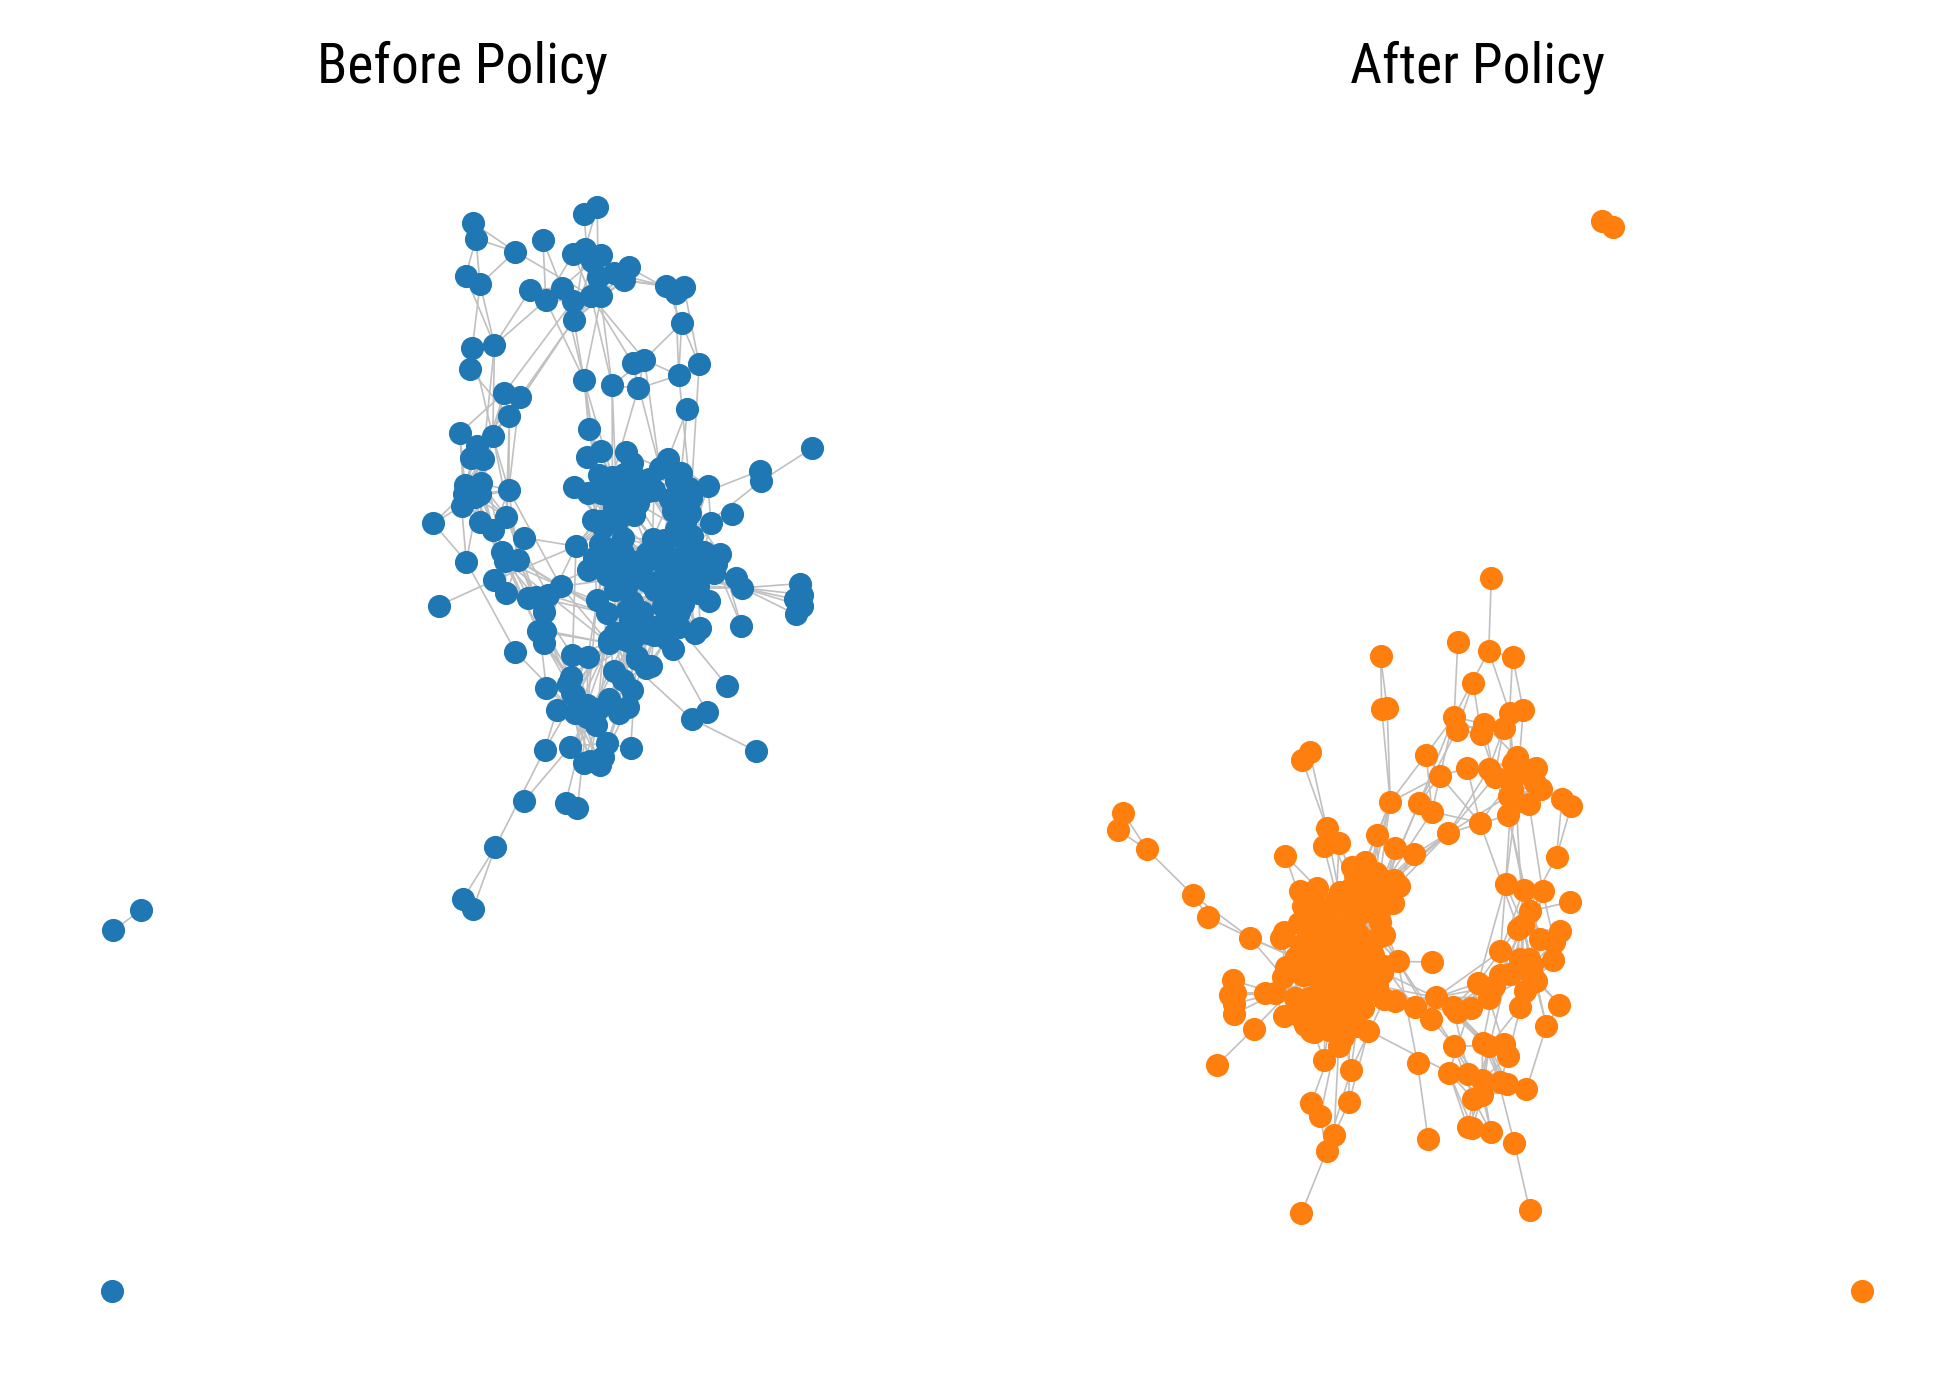

In [16]:
# options pour la visualisation
options = {'node_size': 10, #'node_color': 'skyblue', #or 'teal'
          'width': .3, 'font_size': 5, 'edge_color': 'silver'}
# visualisation du graphe
plt.figure(figsize=(6, 4), dpi=400)
plt.subplot(1, 2, 1)
nx.draw(G_before_policy, with_labels=False, **options, node_color = 'tab:blue')
plt.title('Before Policy')
plt.subplot(1, 2, 2)
nx.draw(G_after_policy, with_labels=False, **options, node_color = 'tab:orange')
plt.title('After Policy')
plt.savefig('graph01.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)
plt.show()

On constate que 3 des chercheurs (noeuds) ne possèdent aucun lien avec l'ensemble du réseau des autres chercheurs. Il s'agit des cherchercheurs avec les identifiants **42896, 42898, 39064**. De plus le chercheur avec l'identifiant **39064** est totalement déconnecté de tout les autres chercheurs et enfin on observe également une collaboration de entre le chercheur **42896 et 42898** isolé du l'ensemble du réseau. 
*Les labels du graphique étant masqué avec l'argument `with_labels=False` pour une meilleur lisibilité. A modifier à `True` pour afficher ces informations.*

In [17]:
# visualisation interactive du réseau pour faciliter l'exploration
# titre du graphique
title_before = 'Network Before Policy'
title_after = 'Network After Policy'

# largeur et hauteur du graphe
WIDTH = 550
HEIGHT = 550

# quelle information afficher quand on passe le curseur sur un noeud
# HOVER_TOOLTIPS = [("@index")]
HOVER_TOOLTIPS = "id: @index, coord: @coord, core: @core, gender: @gender"

# création du graphique - dimension des axes, barre d'outil et titre
plot_before = figure(tooltips = HOVER_TOOLTIPS,
                     width = WIDTH, height = HEIGHT,
                     x_axis_location=None, y_axis_location=None,
                     tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
                     x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1),
                     title=title_before)

plot_after = figure(tooltips = HOVER_TOOLTIPS,
                    width = WIDTH, height = HEIGHT,
                    x_axis_location=None, y_axis_location=None,
                    tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
                    x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1),
                    title=title_after)

# création du graphe avec un spring layout
network_graph_before = from_networkx(G_before_policy, nx.spring_layout, scale=10, center=(0, 0))
network_graph_after = from_networkx(G_after_policy, nx.spring_layout, scale=10, center=(0, 0))

# taille des noeud et couleur à utiliser
network_graph_before.node_renderer.glyph = Circle(radius=0.2, fill_color='blue')
network_graph_after.node_renderer.glyph = Circle(radius=0.2, fill_color='orange')

# opacité des liens et largeur de chaques liens
network_graph_before.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
network_graph_after.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

# ajout du réseau au graphique pour l'affichage
plot_before.renderers.append(network_graph_before)
plot_after.renderers.append(network_graph_after)

show(row(plot_before, plot_after))
#save(plot, filename=f"{title}.html")

**Par la suite de notre étude, de faciliter l'analyse de la structure des deux réseaux sans nécéssairement se préoccupés des poids de chaques liens, nous décidons de supprimer dans les deux graphes les liens étant pondérés à zéro car ces valeurs représentent une absence de lien dans entre les deux chercheurs.**

In [18]:
# identitifions les liens avec un poids égale à zéro
# edges_to_remove = [(u, v) for u, v, data in G_before_policy.edges(data=True) if data.get("weight", 1) == 0]
edges_to_remove = [(u, v) for u, v, data in G_before_policy.edges(data=True) if data["pre_link"] == 0]
G_before = G_before_policy.copy() # copie du graphe initial
G_before.remove_edges_from(edges_to_remove)
edges_to_remove = [(u, v) for u, v, data in G_after_policy.edges(data=True) if data["post_link"] == 0]
G_after = G_after_policy.copy() # copie du graph initial
G_after.remove_edges_from(edges_to_remove)

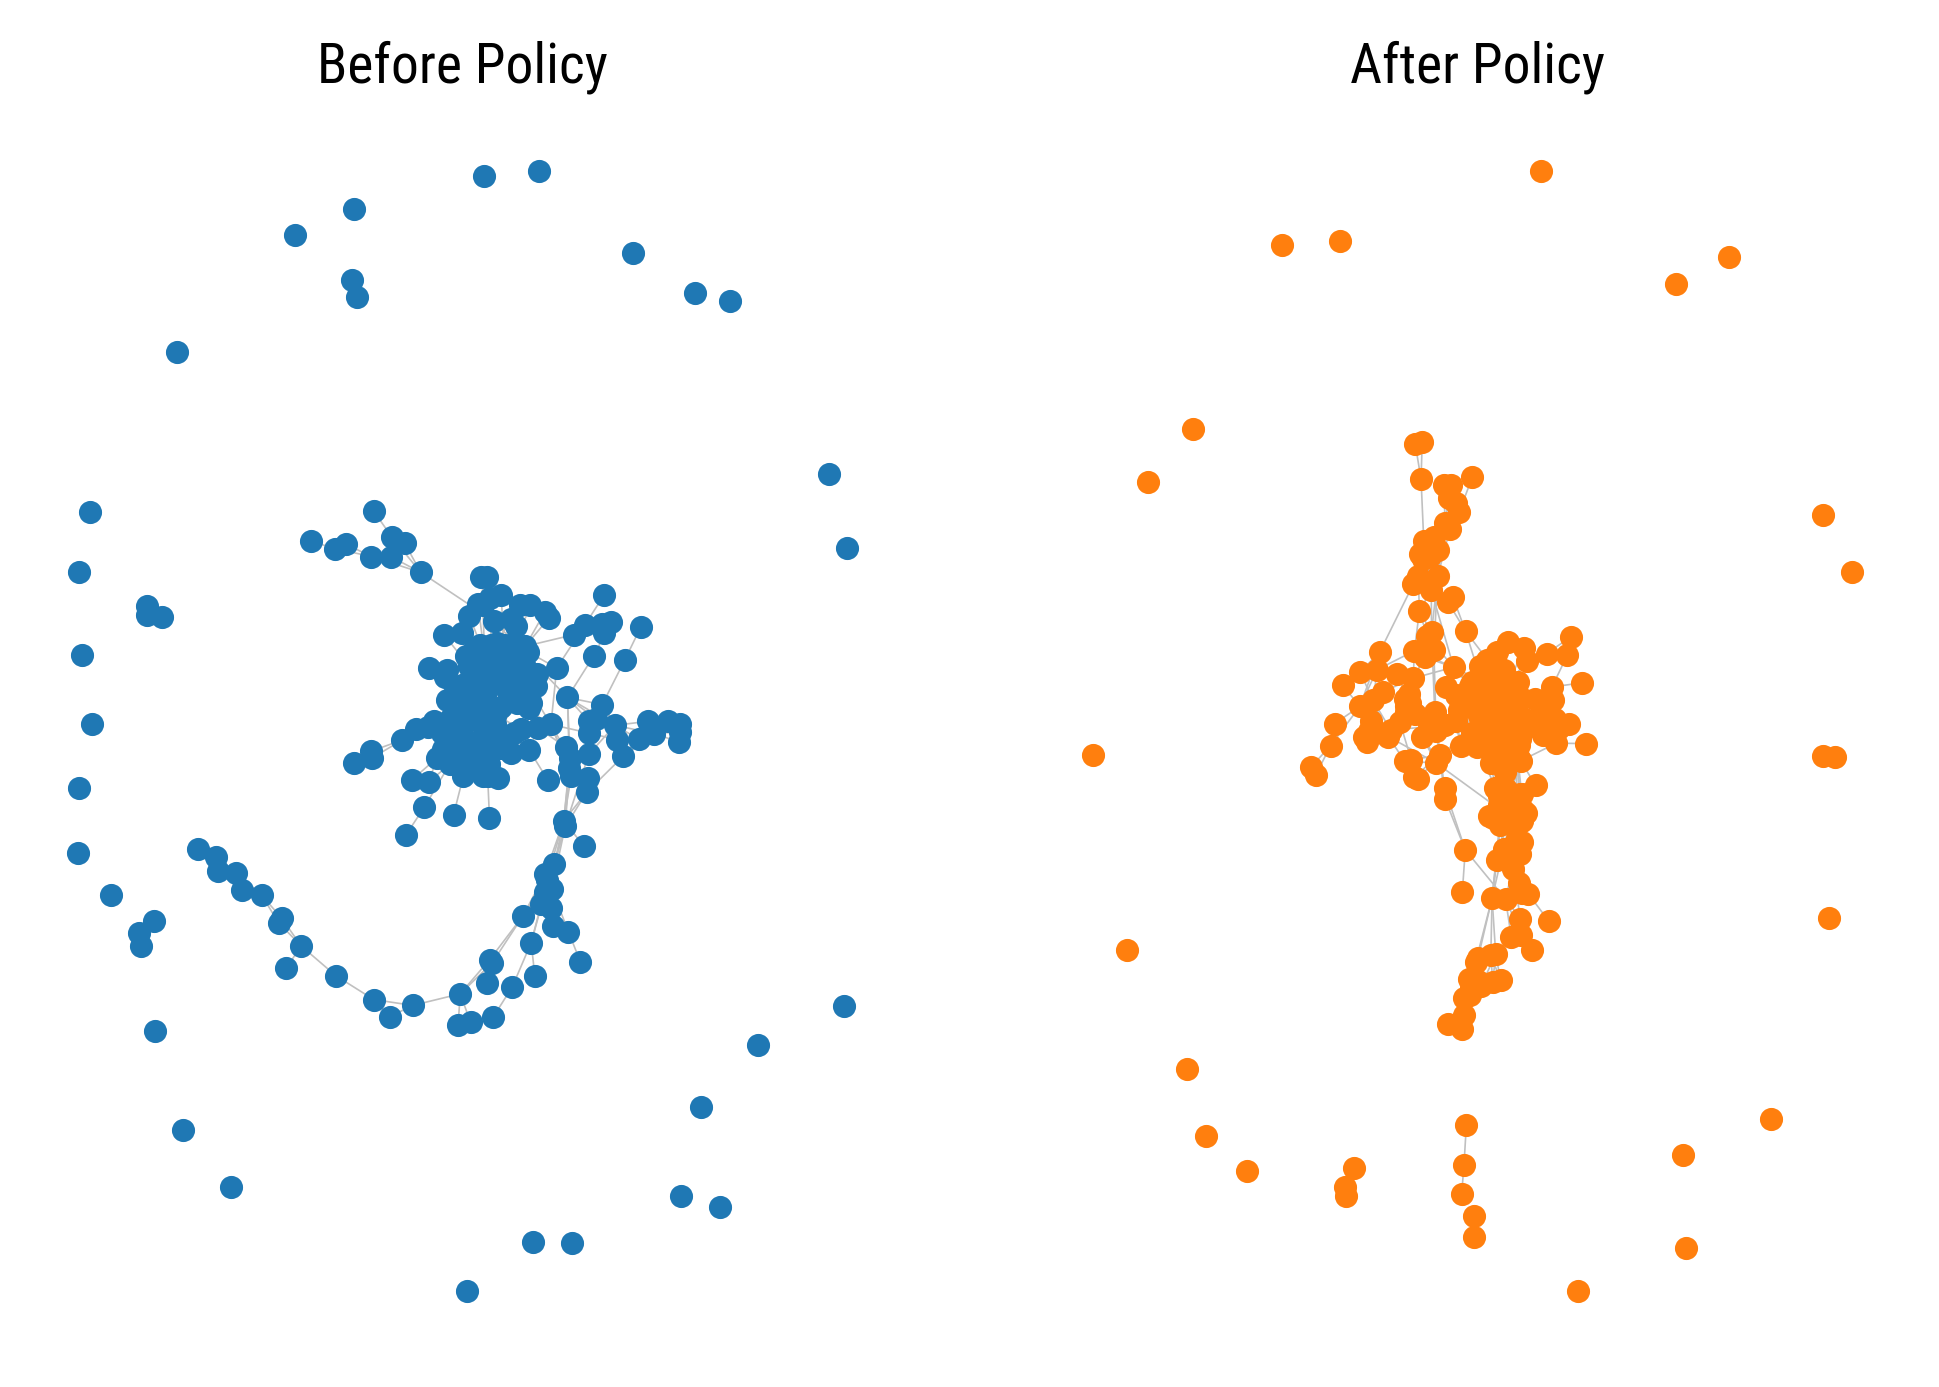

In [19]:
plt.figure(figsize=(6, 4), dpi=400)
plt.subplot(1, 2, 1)
nx.draw(G_before, with_labels=False, **options)
plt.title('Before Policy')
plt.subplot(1, 2, 2)
nx.draw(G_after, with_labels=False, **options, node_color='tab:orange')
plt.title('After Policy')
plt.savefig('graph02.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)
plt.show()

## Objectif 1

In [20]:
# calcul des statistiques descriptives du réseau pour chaque période (analyse de structure)
def calculate_network_stats(G, weight: str = None) -> dict:
    """
    G : Graphe sur lequel les calculs seront effectuées
    weigth : Chaîne de caractère de l'attribut des poids du réseau
    """
    num_nodes = G.number_of_nodes() # information identique pour les deux périodes
    num_edges = G.number_of_edges()
    avg_degree = sum(dict(G.degree(weight=weight)).values()) / num_nodes # prise en compte des poids ou non
    return {
        'Nombre de noeuds': num_nodes,
        'Nombre d\'arêtes': num_edges,
        'Degré moyen': avg_degree,
        'Densité du réseau': nx.density(G) # information identique pour les deux périodes
    }

# calcul des statistiques pour chaque période
stats_before_policy = calculate_network_stats(G_before)
stats_after_policy = calculate_network_stats(G_after)

In [21]:
# affichage des statistiques (avant)
print("Statistiques pour la période avant la mise en place de la politique :")
pd.DataFrame.from_dict(stats_before_policy, orient='index', columns=['Valeur'])

Statistiques pour la période avant la mise en place de la politique :


,Valeur
Nombre de noeuds,252.000000
Nombre d'arêtes,693.000000
Degré moyen,5.500000
Densité du réseau,0.021912


In [22]:
# affichage des statistiques (après)
print("Statistiques pour la période après la mise en place de la politique :")
pd.DataFrame.from_dict(stats_after_policy, orient='index', columns=['Valeur'])

Statistiques pour la période après la mise en place de la politique :


,Valeur
Nombre de noeuds,252.000000
Nombre d'arêtes,739.000000
Degré moyen,5.865079
Densité du réseau,0.023367


A traver le calcul de la densité du réseau avant la mise en place de la politique, on oberve que $2,19\%$ des liens sont présent dans le réseaux sur la totalité des liens possibles pouvant existé dans notre réseau ce qui montre que nous avons à faire à un réseau très peu dense. Dans la seconde période cette densité augement à $2,33\%$, ce qui suggère une augmentation du nombre de collaboration entre les deux périodes.

Au regard du dégré moyen de chaque période, on remarque qu'après la mise en place de la politique que le nombre moyen de la collaboration par chercheurs augmente très légerement, ceci signifie qu'en moyenne les chercheurs ont une activité de collaboration légèrement plus importante qu'avant la mise en place de la politique.

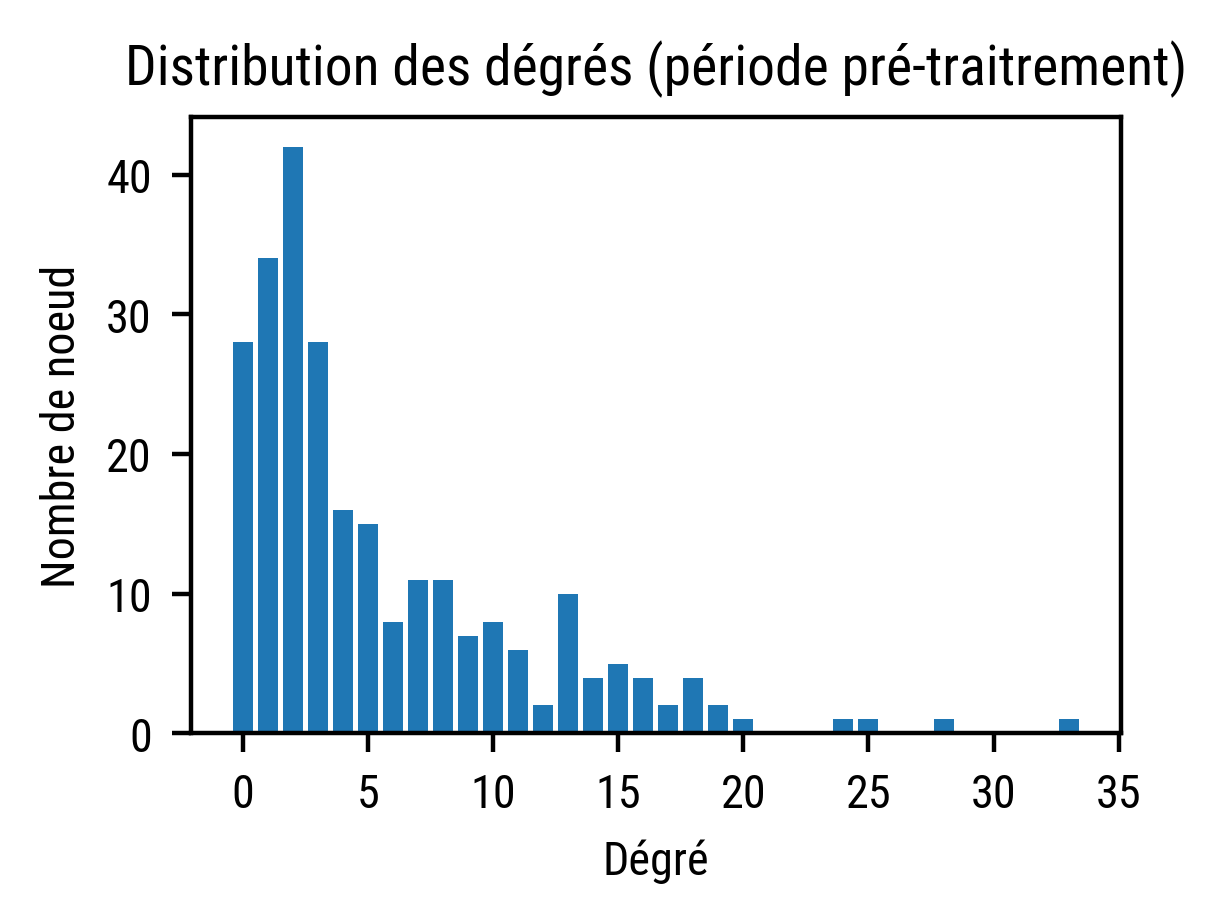

In [23]:
# distribution des dégrés pondérés avant la mise en place de la politique (avec le graphe original)
weighted_degree = G_before_policy.degree(weight='pre_link')
weighted_degree = sorted((d for n, d in weighted_degree), reverse=True)
fig, ax = plt.subplots(figsize=(3, 2), dpi=400)
ax.bar(*np.unique(weighted_degree, return_counts=True))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlabel('Dégré')
ax.set_ylabel('Nombre de noeud')
ax.set_title('Distribution des dégrés (période pré-traitrement)')
plt.savefig('graph03.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)
plt.show()

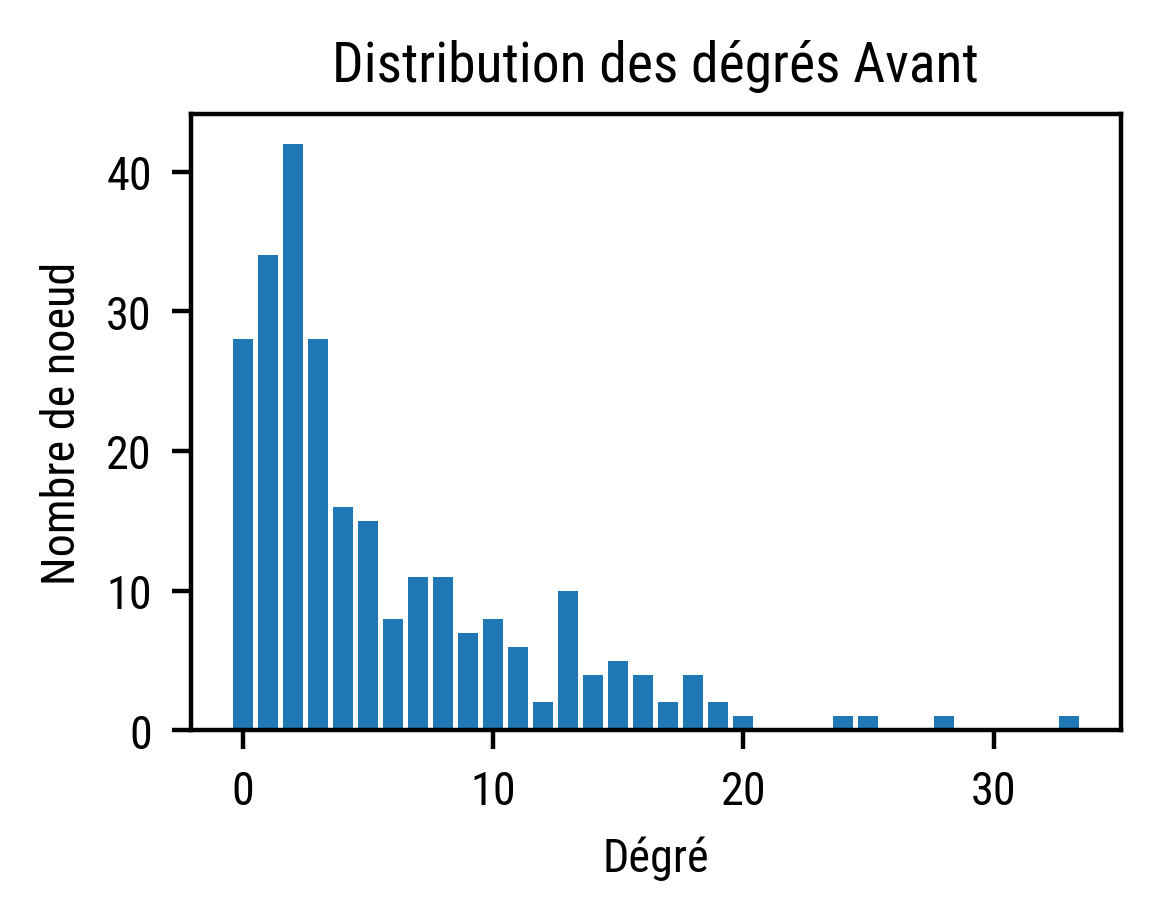

In [24]:
# distribution des dégrés avant la mise en place de la politique
# (avec le graphe dont les liens ont été supprimé, doit fournir le même résultat)
degree_count = nx.degree_histogram(G_before)
degree_range = [_ for _ in range(0, len(degree_count))]
hist_data = (degree_range, degree_count)
plt.figure(figsize = (3, 2), dpi = 400)
plt.bar(*hist_data)
plt.xlabel('Dégré')
plt.ylabel('Nombre de noeud')
plt.title('Distribution des dégrés Avant')
plt.savefig('graph04.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)
plt.show()

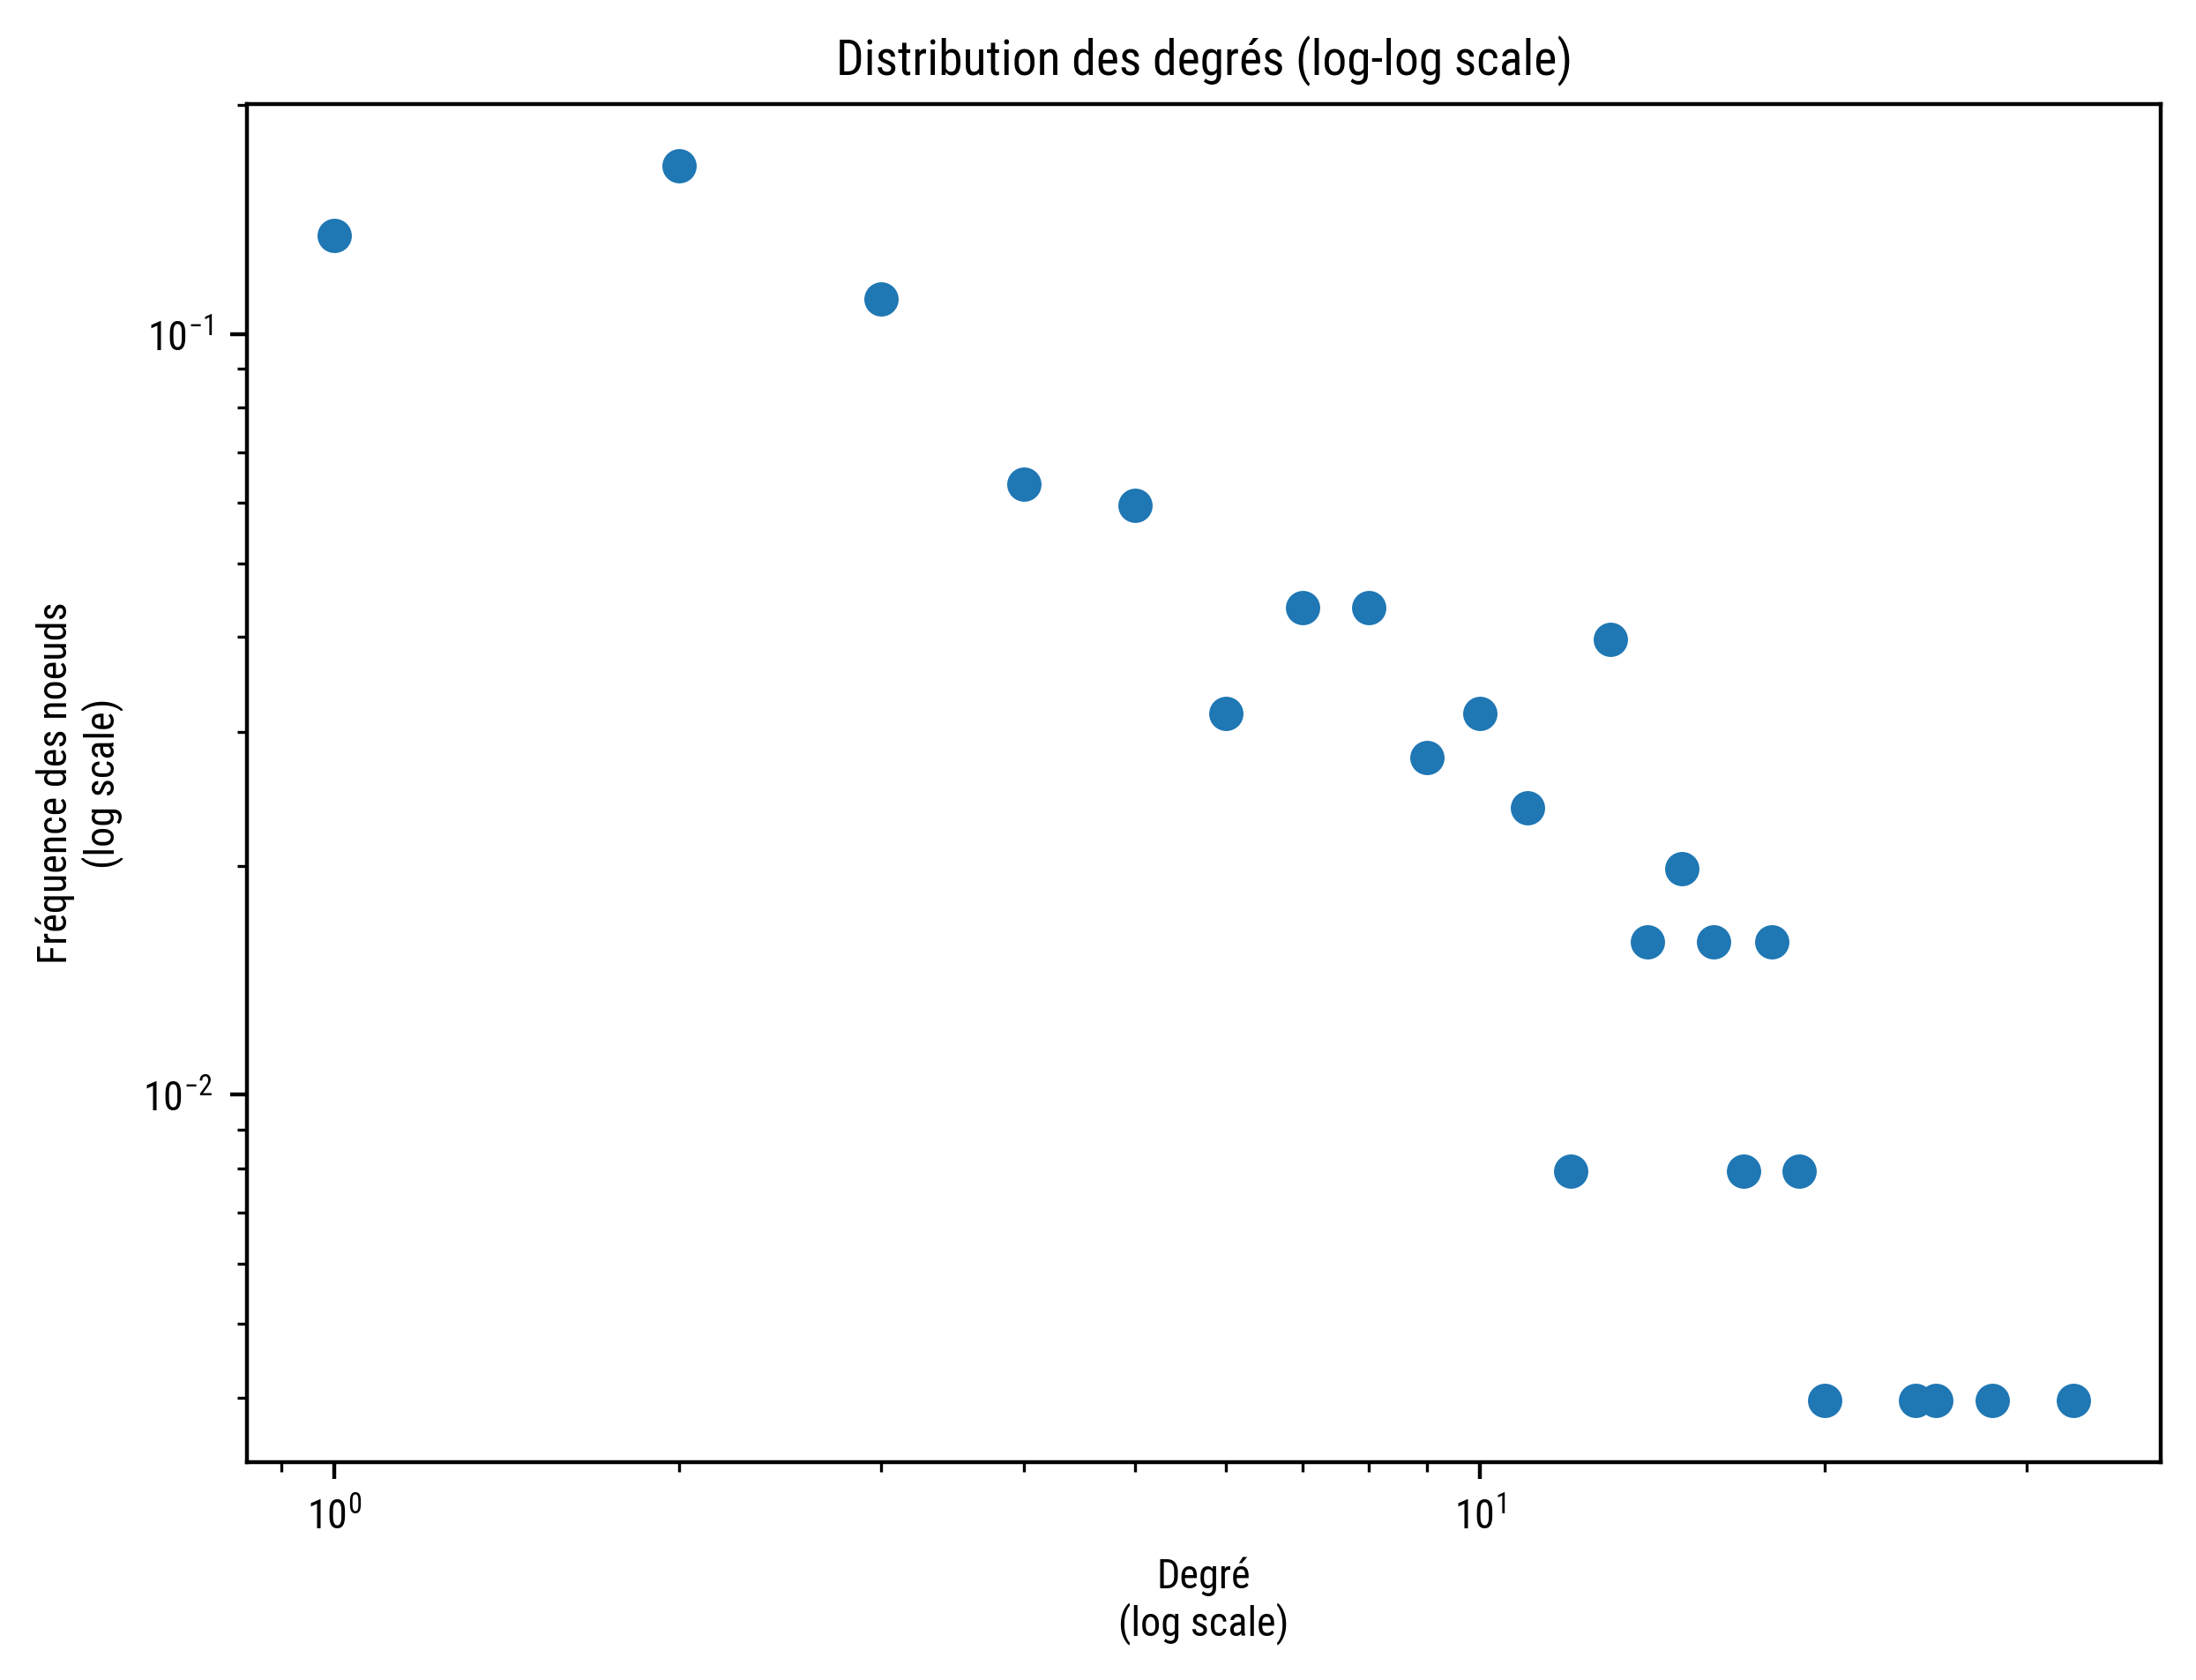

In [25]:
N = nodes_df.shape[0] # nombres de noeuds
degree_count_normalise = [val/N for val in degree_count]

plt.figure(figsize=(7, 5), dpi=400)
plt.title('Distribution des degrés (log-log scale)')

plt.xscale("log", base=10)
plt.yscale("log", base=10)

plt.plot(degree_range, degree_count_normalise, 'o')

plt.xlabel('Degré\n(log scale)')
plt.ylabel('Fréquence des noeuds\n(log scale)')

plt.savefig('graph05.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)

plt.show()

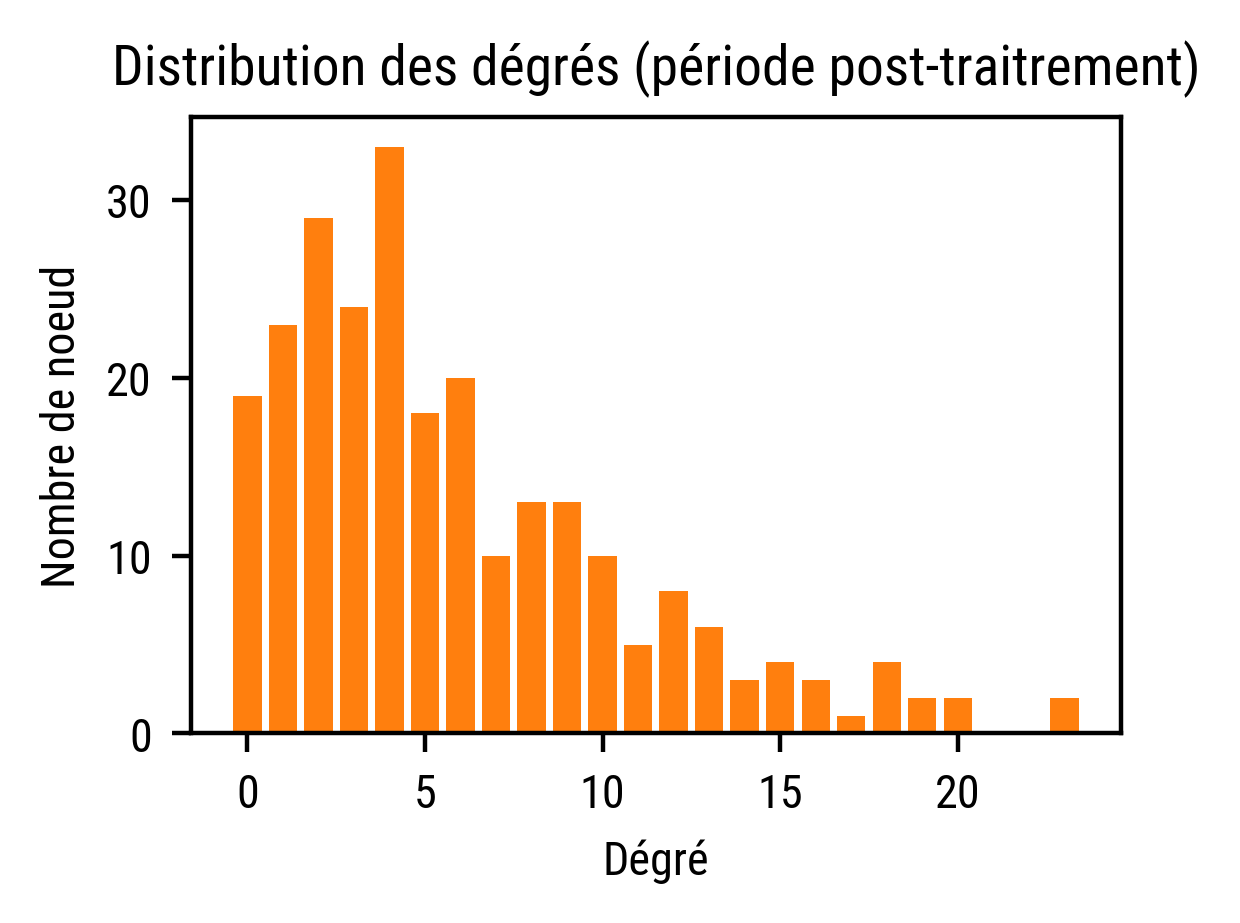

In [26]:
# distribution des dégrés pondérés après la mise en place de la politique (avec le graphe original)
weighted_degree = G_after_policy.degree(weight='post_link')
weighted_degree = sorted((d for n, d in weighted_degree), reverse=True)
plt.figure(figsize = (3, 2), dpi = 400)
plt.bar(*np.unique(weighted_degree, return_counts=True), color = 'tab:orange')
plt.xlabel('Dégré')
plt.ylabel('Nombre de noeud')
plt.title('Distribution des dégrés (période post-traitrement)')
plt.savefig('graph06.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)
plt.show()

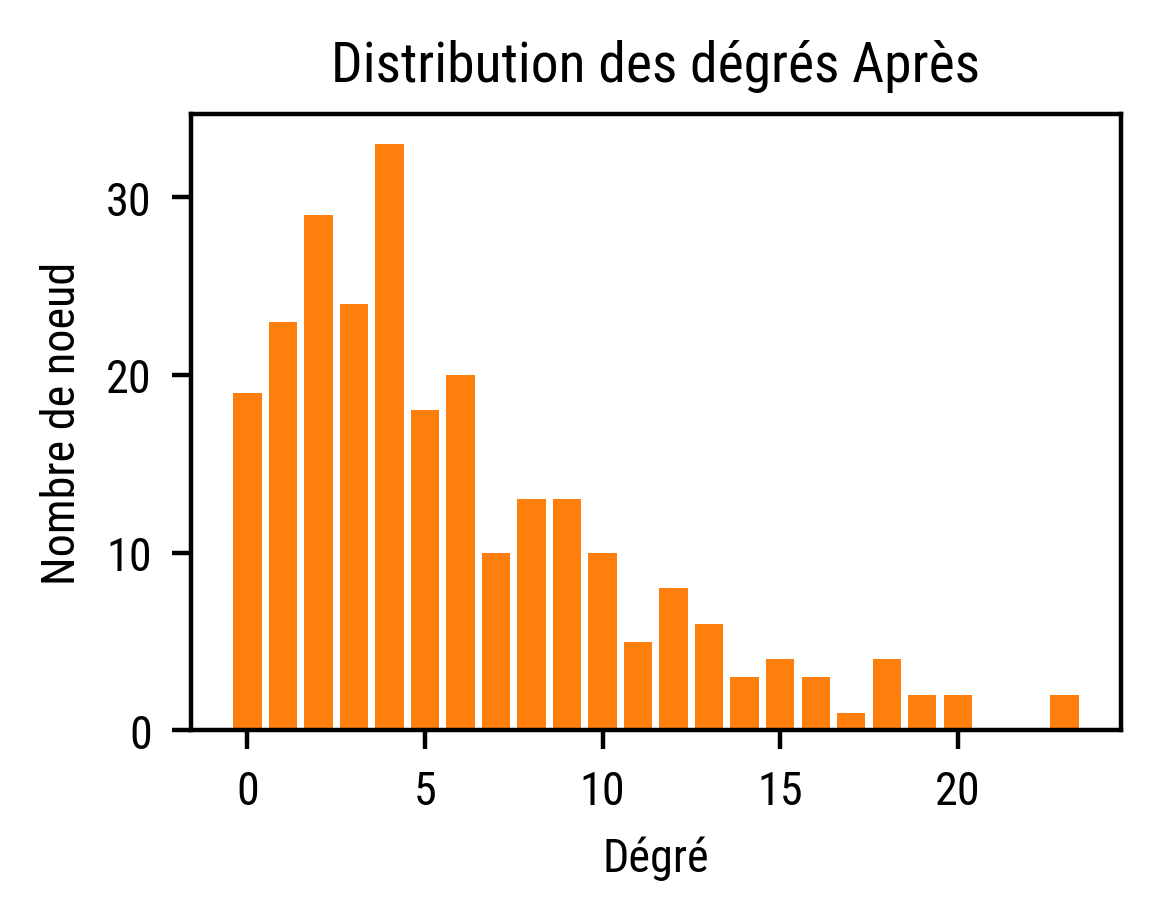

In [27]:
# distribution des dégrés après la mise en place de la politique
# (avec le graphe dont les liens ont été supprimé, doit fournir le même résultat)
degree_count = nx.degree_histogram(G_after)
degree_range = [_ for _ in range(0, len(degree_count))]
hist_data = (degree_range, degree_count)
plt.figure(figsize = (3, 2), dpi = 400)
plt.bar(*hist_data, color = 'tab:orange')
plt.xlabel('Dégré')
plt.ylabel('Nombre de noeud')
plt.title('Distribution des dégrés Après')
plt.savefig('graph07.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)
plt.show()

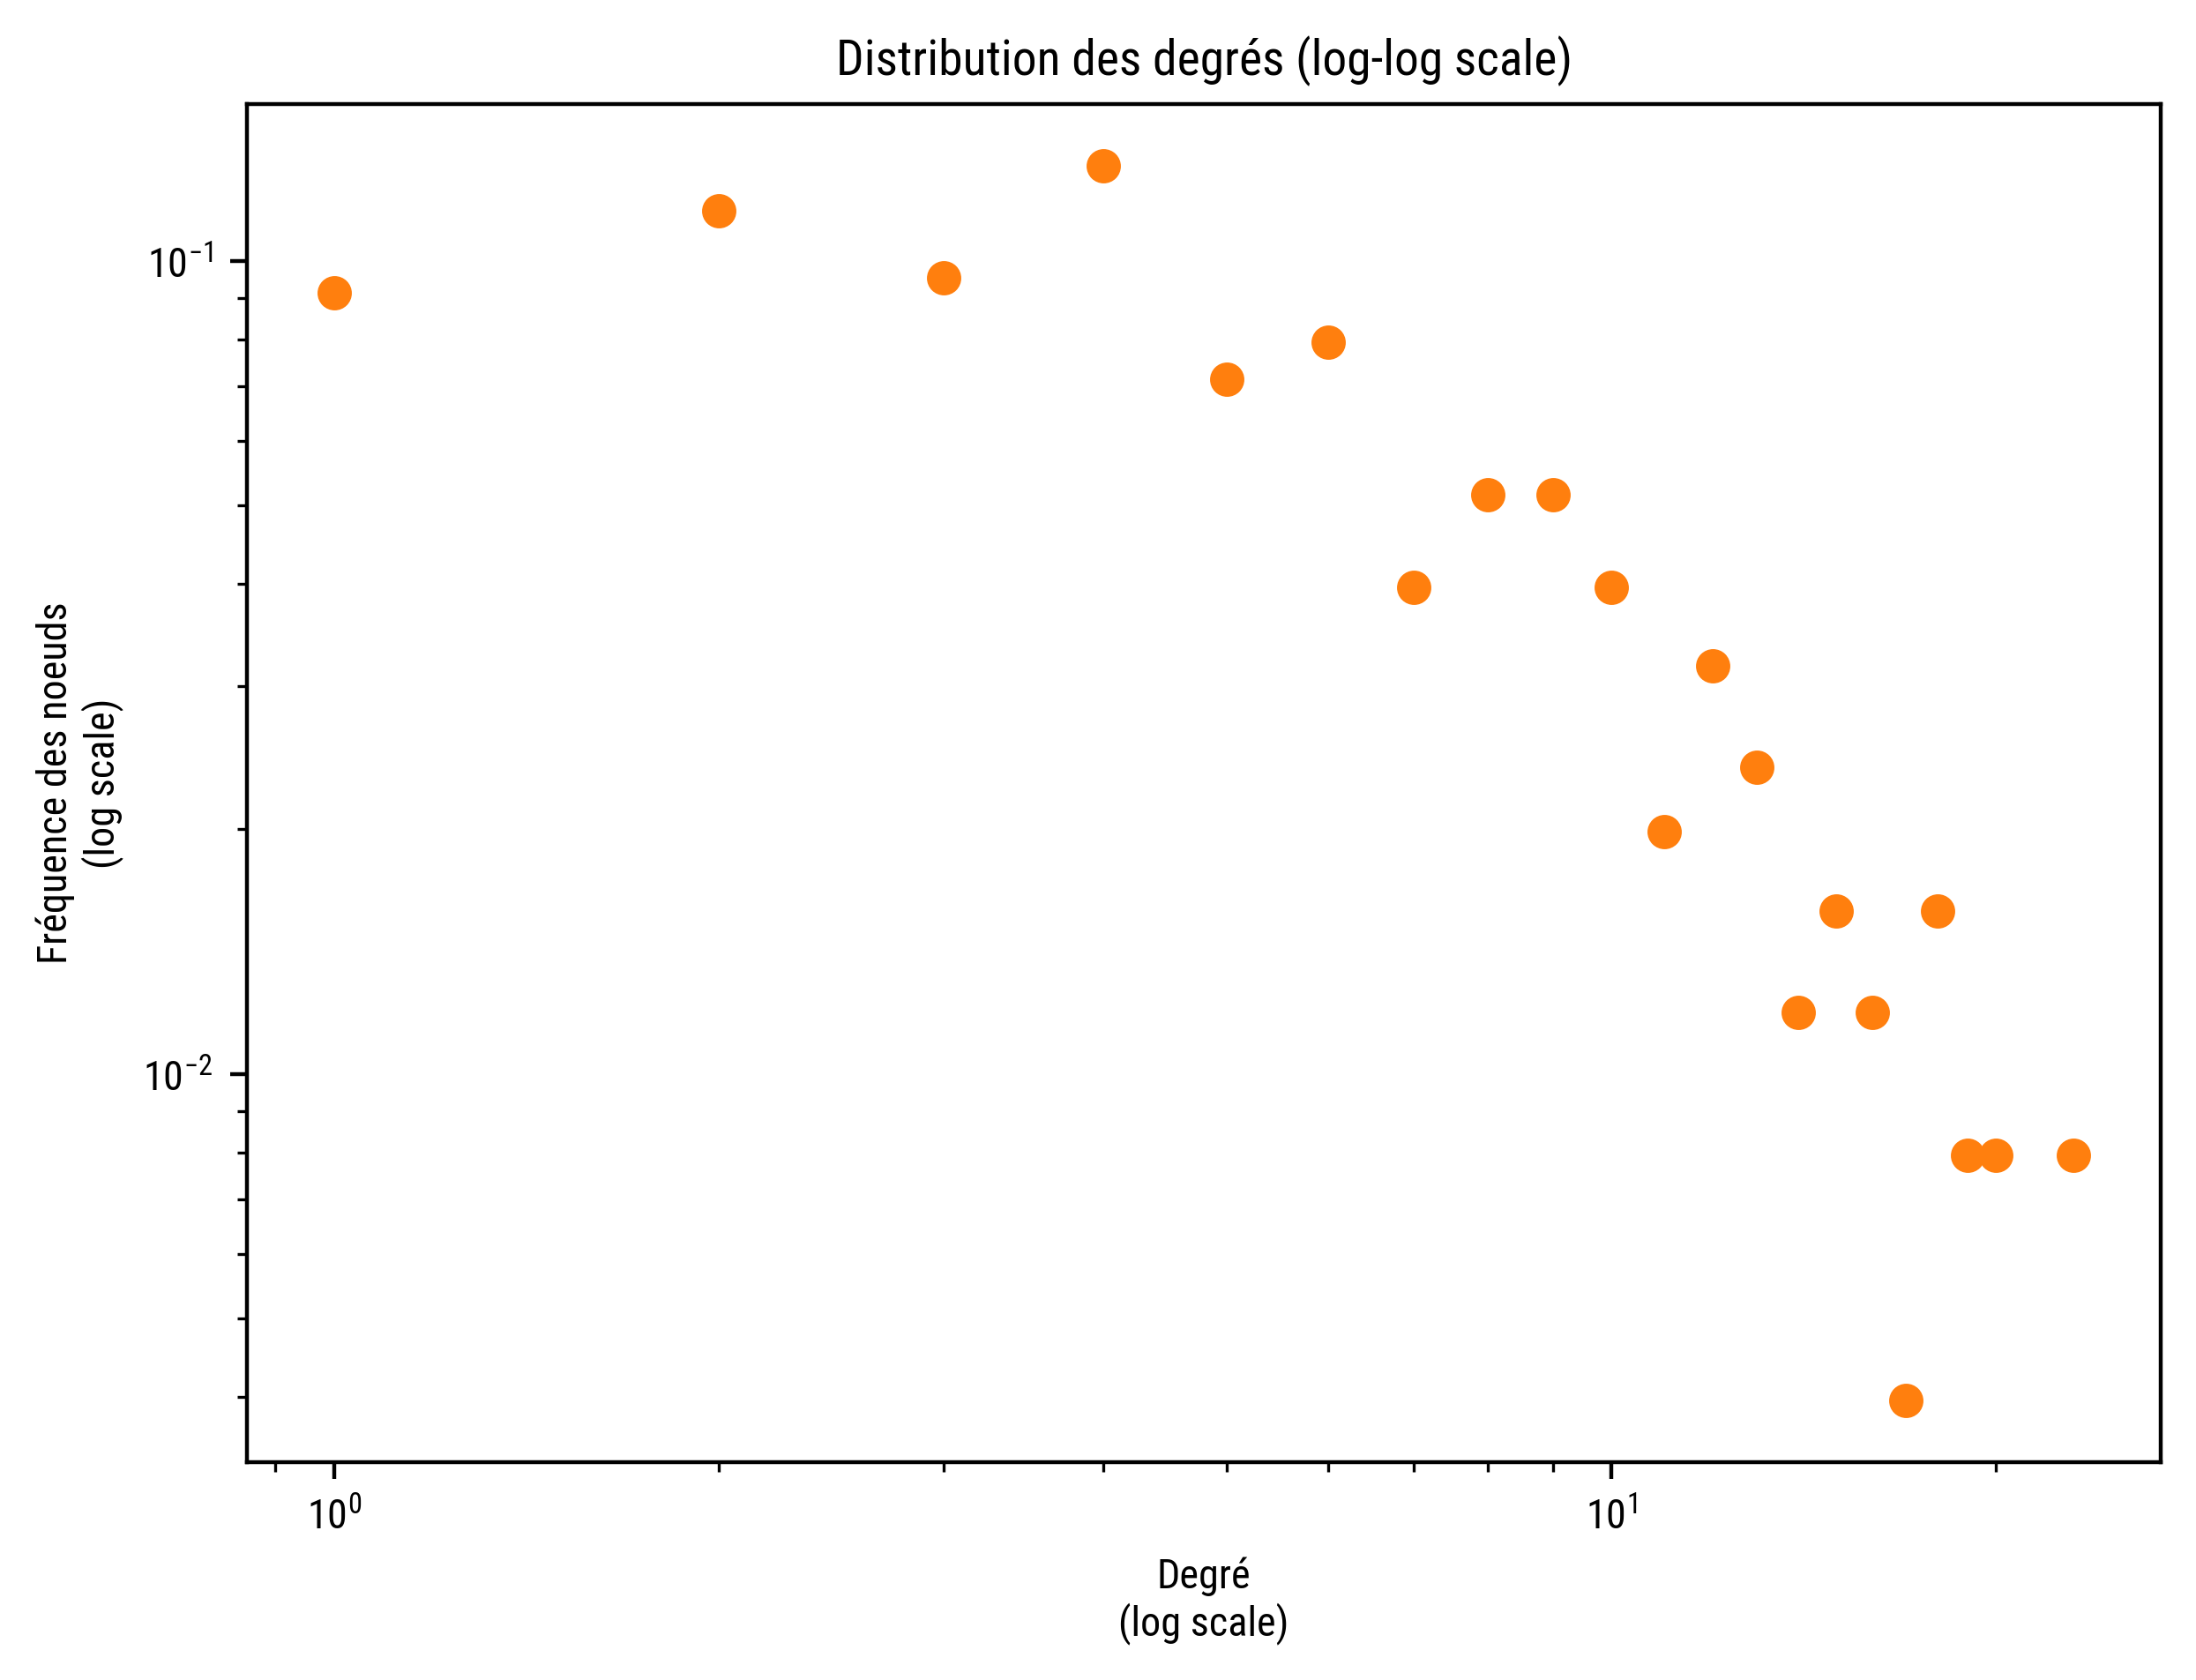

In [28]:
degree_count_normalise = [val/N for val in degree_count]

plt.figure(figsize=(7, 5), dpi=400)
plt.title('Distribution des degrés (log-log scale)')

plt.xscale("log", base=10)
plt.yscale("log", base=10)

plt.plot(degree_range, degree_count_normalise, 'o',
         color = 'tab:orange')

plt.xlabel('Degré\n(log scale)')
plt.ylabel('Fréquence des noeuds\n(log scale)')

plt.savefig('graph08.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)

plt.show()

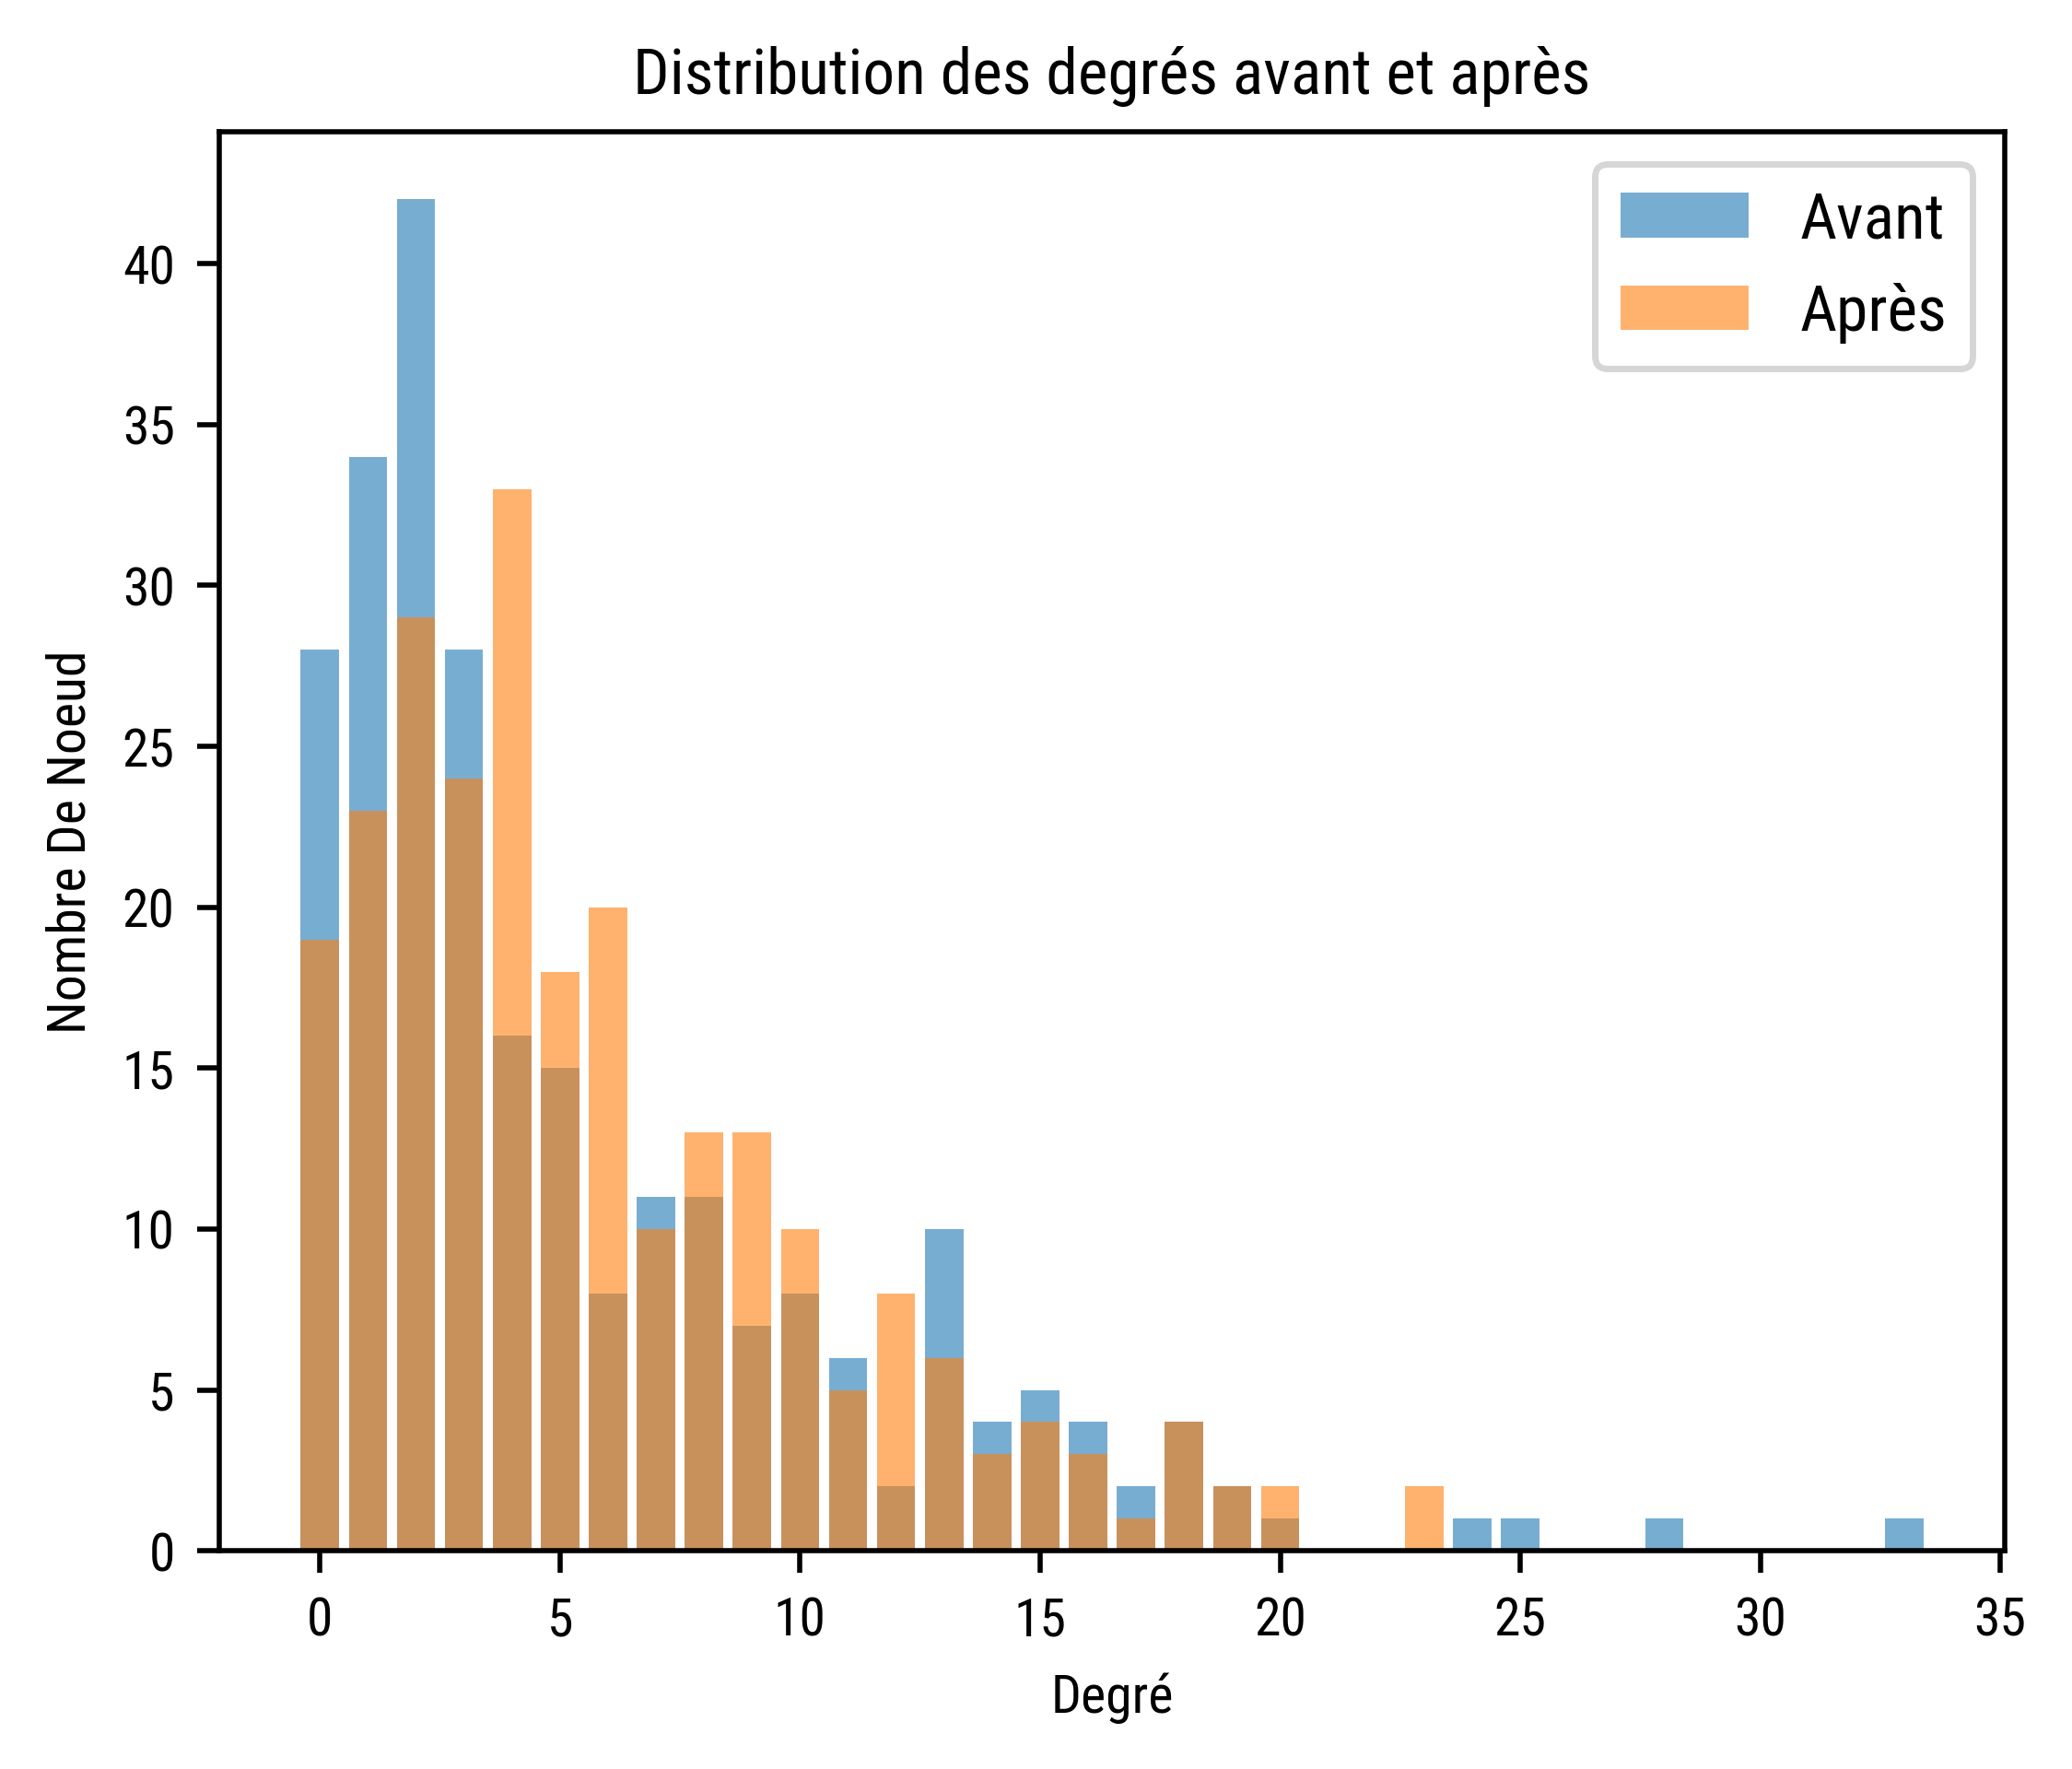

In [29]:
# distribution des degrés dans le même graphique
degree_count_before = nx.degree_histogram(G_before)
degree_count_after = nx.degree_histogram(G_after)
degree_range_before = np.arange(len(degree_count_before))
degree_range_after = np.arange(len(degree_count_after))
fig, ax = plt.subplots(figsize=(5, 4), dpi=500)
ax.bar(degree_range_before, degree_count_before, label="Avant",
      alpha=0.6)
ax.bar(degree_range_after, degree_count_after, label="Après",
      alpha=0.6)
ax.legend(loc="best")
ax.set_xlabel("Degré")
ax.set_ylabel("Nombre De Noeud")
ax.set_title("Distribution des degrés avant et après")
plt.savefig('graph01Correction.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)
plt.show()

Des résultats obtenue à travers le calcul de la distribution des dégrés, nous pouvons constatés dans un premier temps de façon générale, que dans la période avant la mise en place de la politique et celle d'après, la plupart des chercheurs ont réseaux de collaborations plutôt restreint $\le 15$ et très peu de chercheurs ont un nombre de collaboration $> 15$. Enfin dans un second temps nous pouvons également remarqué que après la mise en place de la politique, la plupart des chercheurs qui avaient un nombre important de collaboration ont perdue à peu près une dizaine de collaborateurs et par conséquent le nombre de chercheurs avec un nombre de restreint de collaboration augmente.

- **Degree Centrality**
    - Centrality defines how important a node is within a network (centralité de dégré = dégré)
- **Eigenvector Centrality**
    - Eigenvector centrality generalizes degree centrality by incorporating the importance of the neighbors (undirected)
- **Betweenness Centrality**
    - Centrality in terms of how you connect others(information broker)
- **Closeness Centrality**
    - Centrality in terms of how fast you can reach others
 
All centrality measures defined so far measure centrality for a single node.
- **Friendship Patterns**
    - Transitivity and Reciprocity, **Transitivity is when a friend of my friend is my friend**.
    - Transitivity in a social network leads to a denser graph, which in turn is closer to a complete graph
    - We can determine how close graphs are to the complete graph by measuring transitivity
    - **Clustering coefficient** measures transitivity in undirected graphs


Dans la suite on s'interesse maintenant à identifier quels sont les chercheurs les plus importants dans notre réseaux, et identifier si ceux sont identiques sur l'ensemble des deux périodes considérées et au regard de la mesure d'importance employés.
Pour mesurer l'importance d'un chercheur dans notre réseau, ici nous utiliserons nottament des mesures de centralités et nottament **la centralité de dégrée (degree centrality)** qui définit un chercheur comme important si ce chercheur possède un nombre important de collaborateur et **la centralité d'intermmédiarité (betweenness centrality)** qui lui indique un chercheur comme important si il permet la mise en relation avec d'autres collaborateurs.

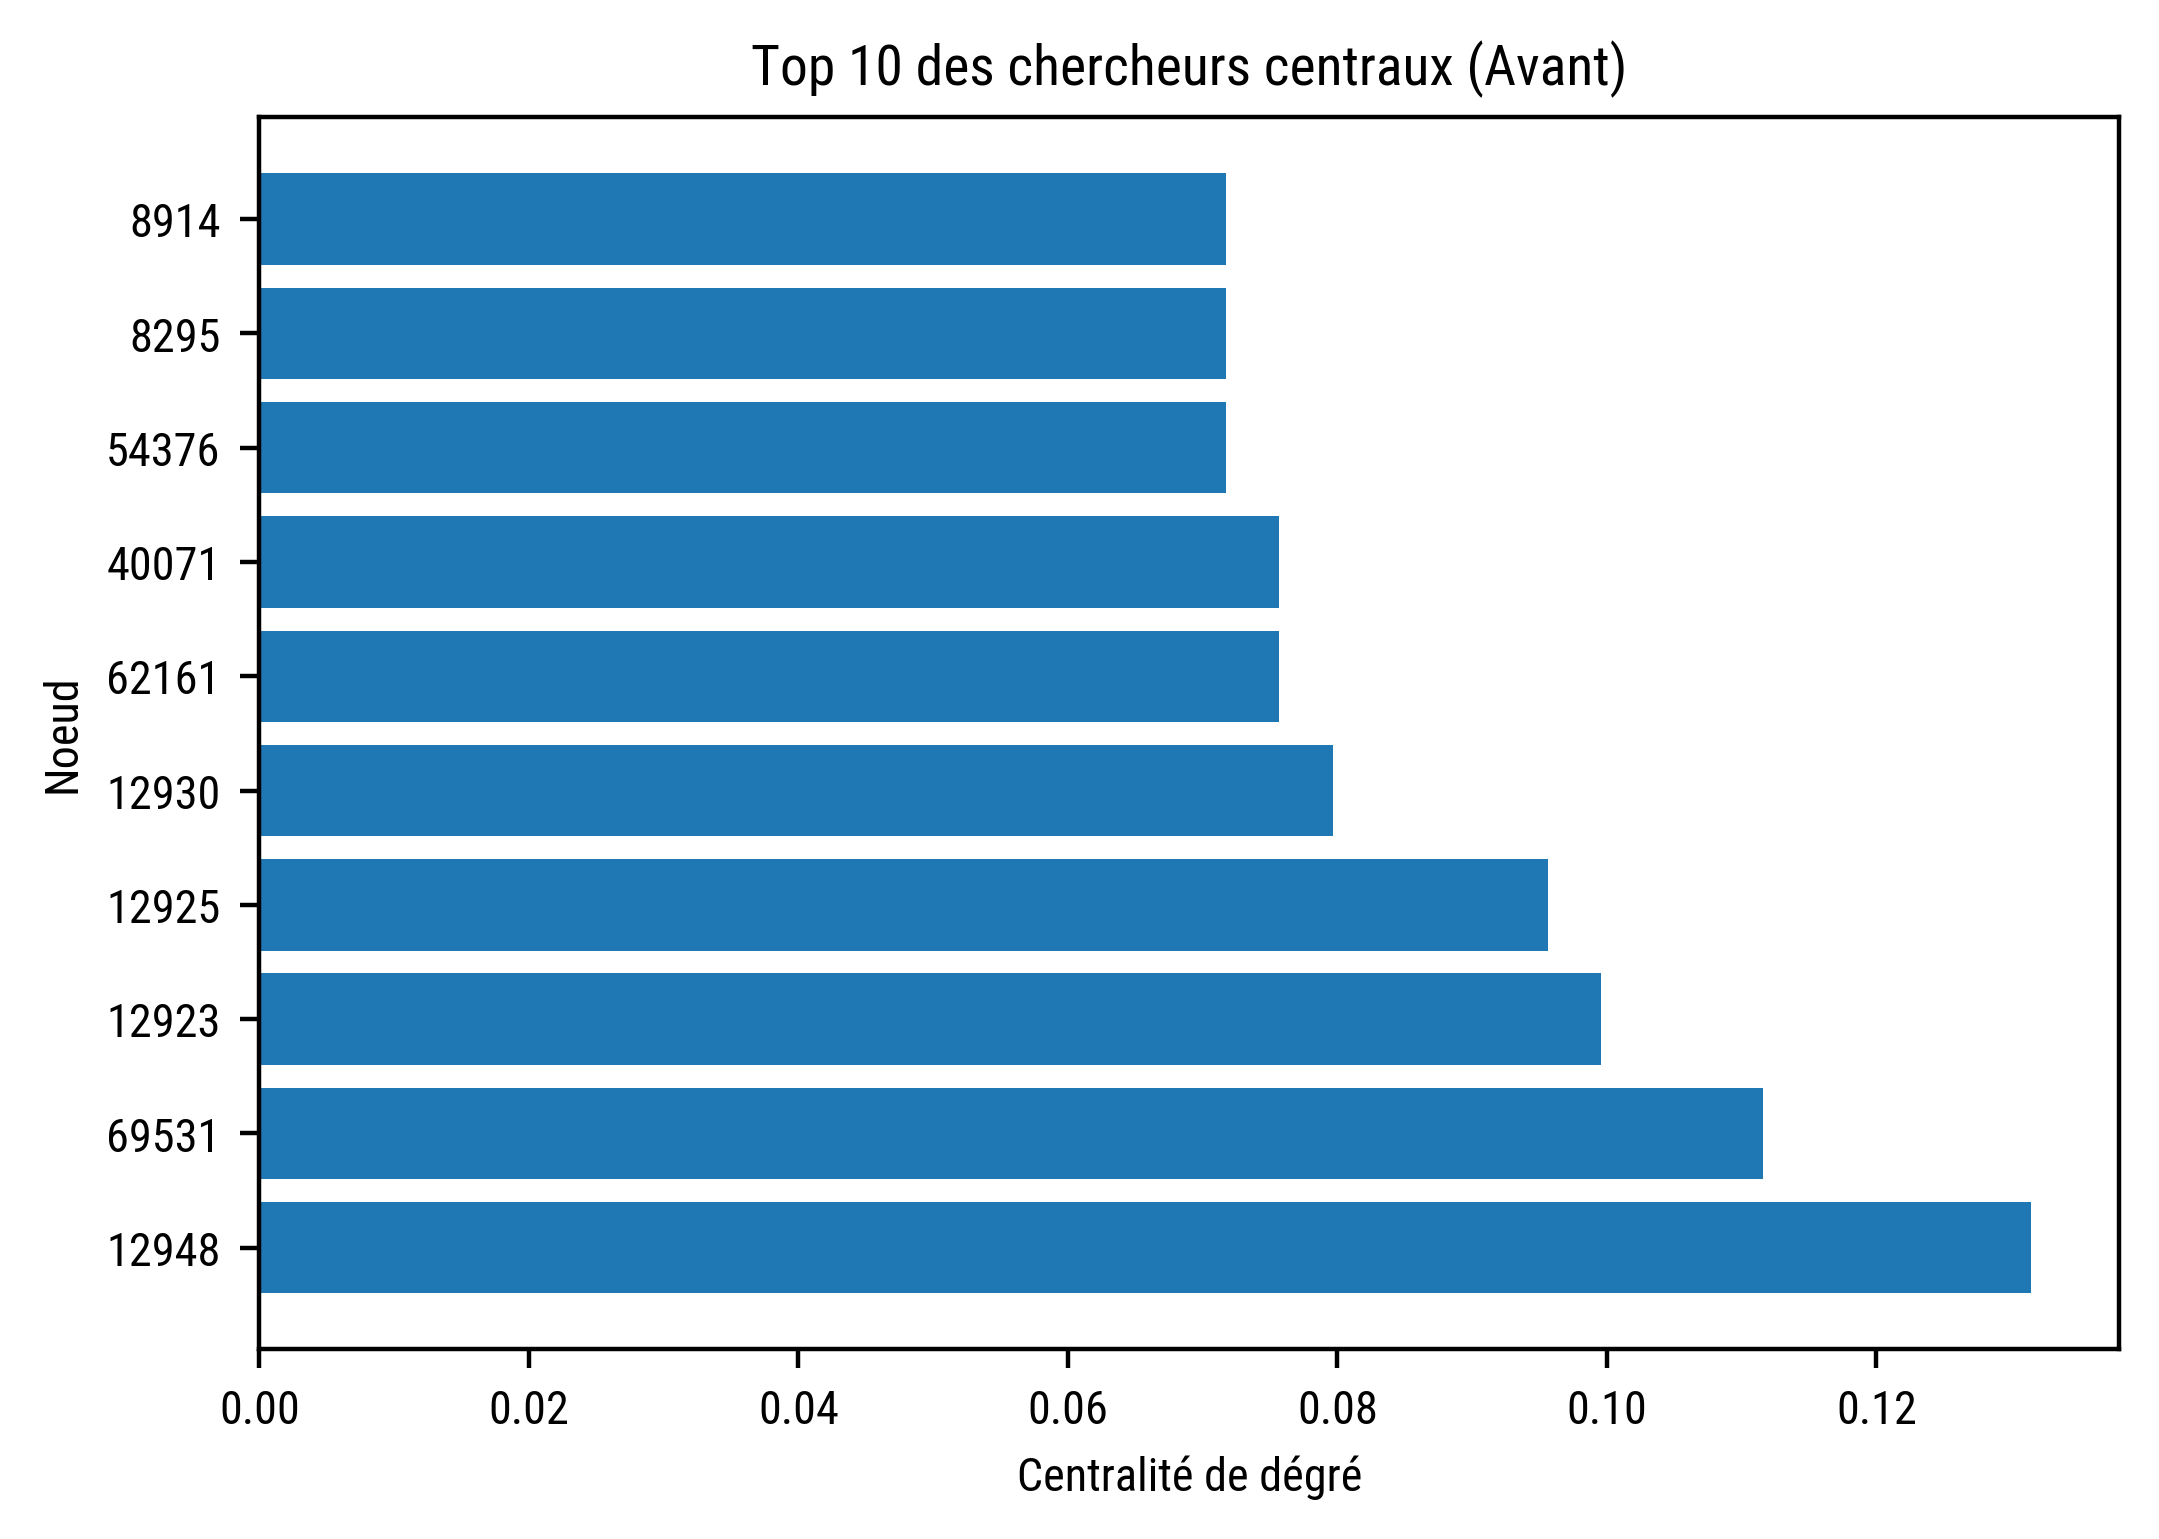

In [30]:
# centralité de dégrés avant la mise en place de la politique (Avant)
number_of_element_to_inspect = 10
degree_centra = sorted(nx.degree_centrality(G_before).items(), key=lambda x: x[1], reverse=True)[:number_of_element_to_inspect]
nodes = [str(n) for n, d in degree_centra]
degree = [d for n, d in degree_centra]
plt.figure(figsize=(6, 4), dpi=400)
plt.barh(nodes, degree)
plt.xlabel("Centralité de dégré")
plt.ylabel("Noeud")
# plt.title(f"Top {number_of_element_to_inspect} des chercheurs ayant le plus de colaborateurs (Avant)")
plt.title(f"Top {number_of_element_to_inspect} des chercheurs centraux (Avant)")
plt.savefig('graph09.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)
plt.show()

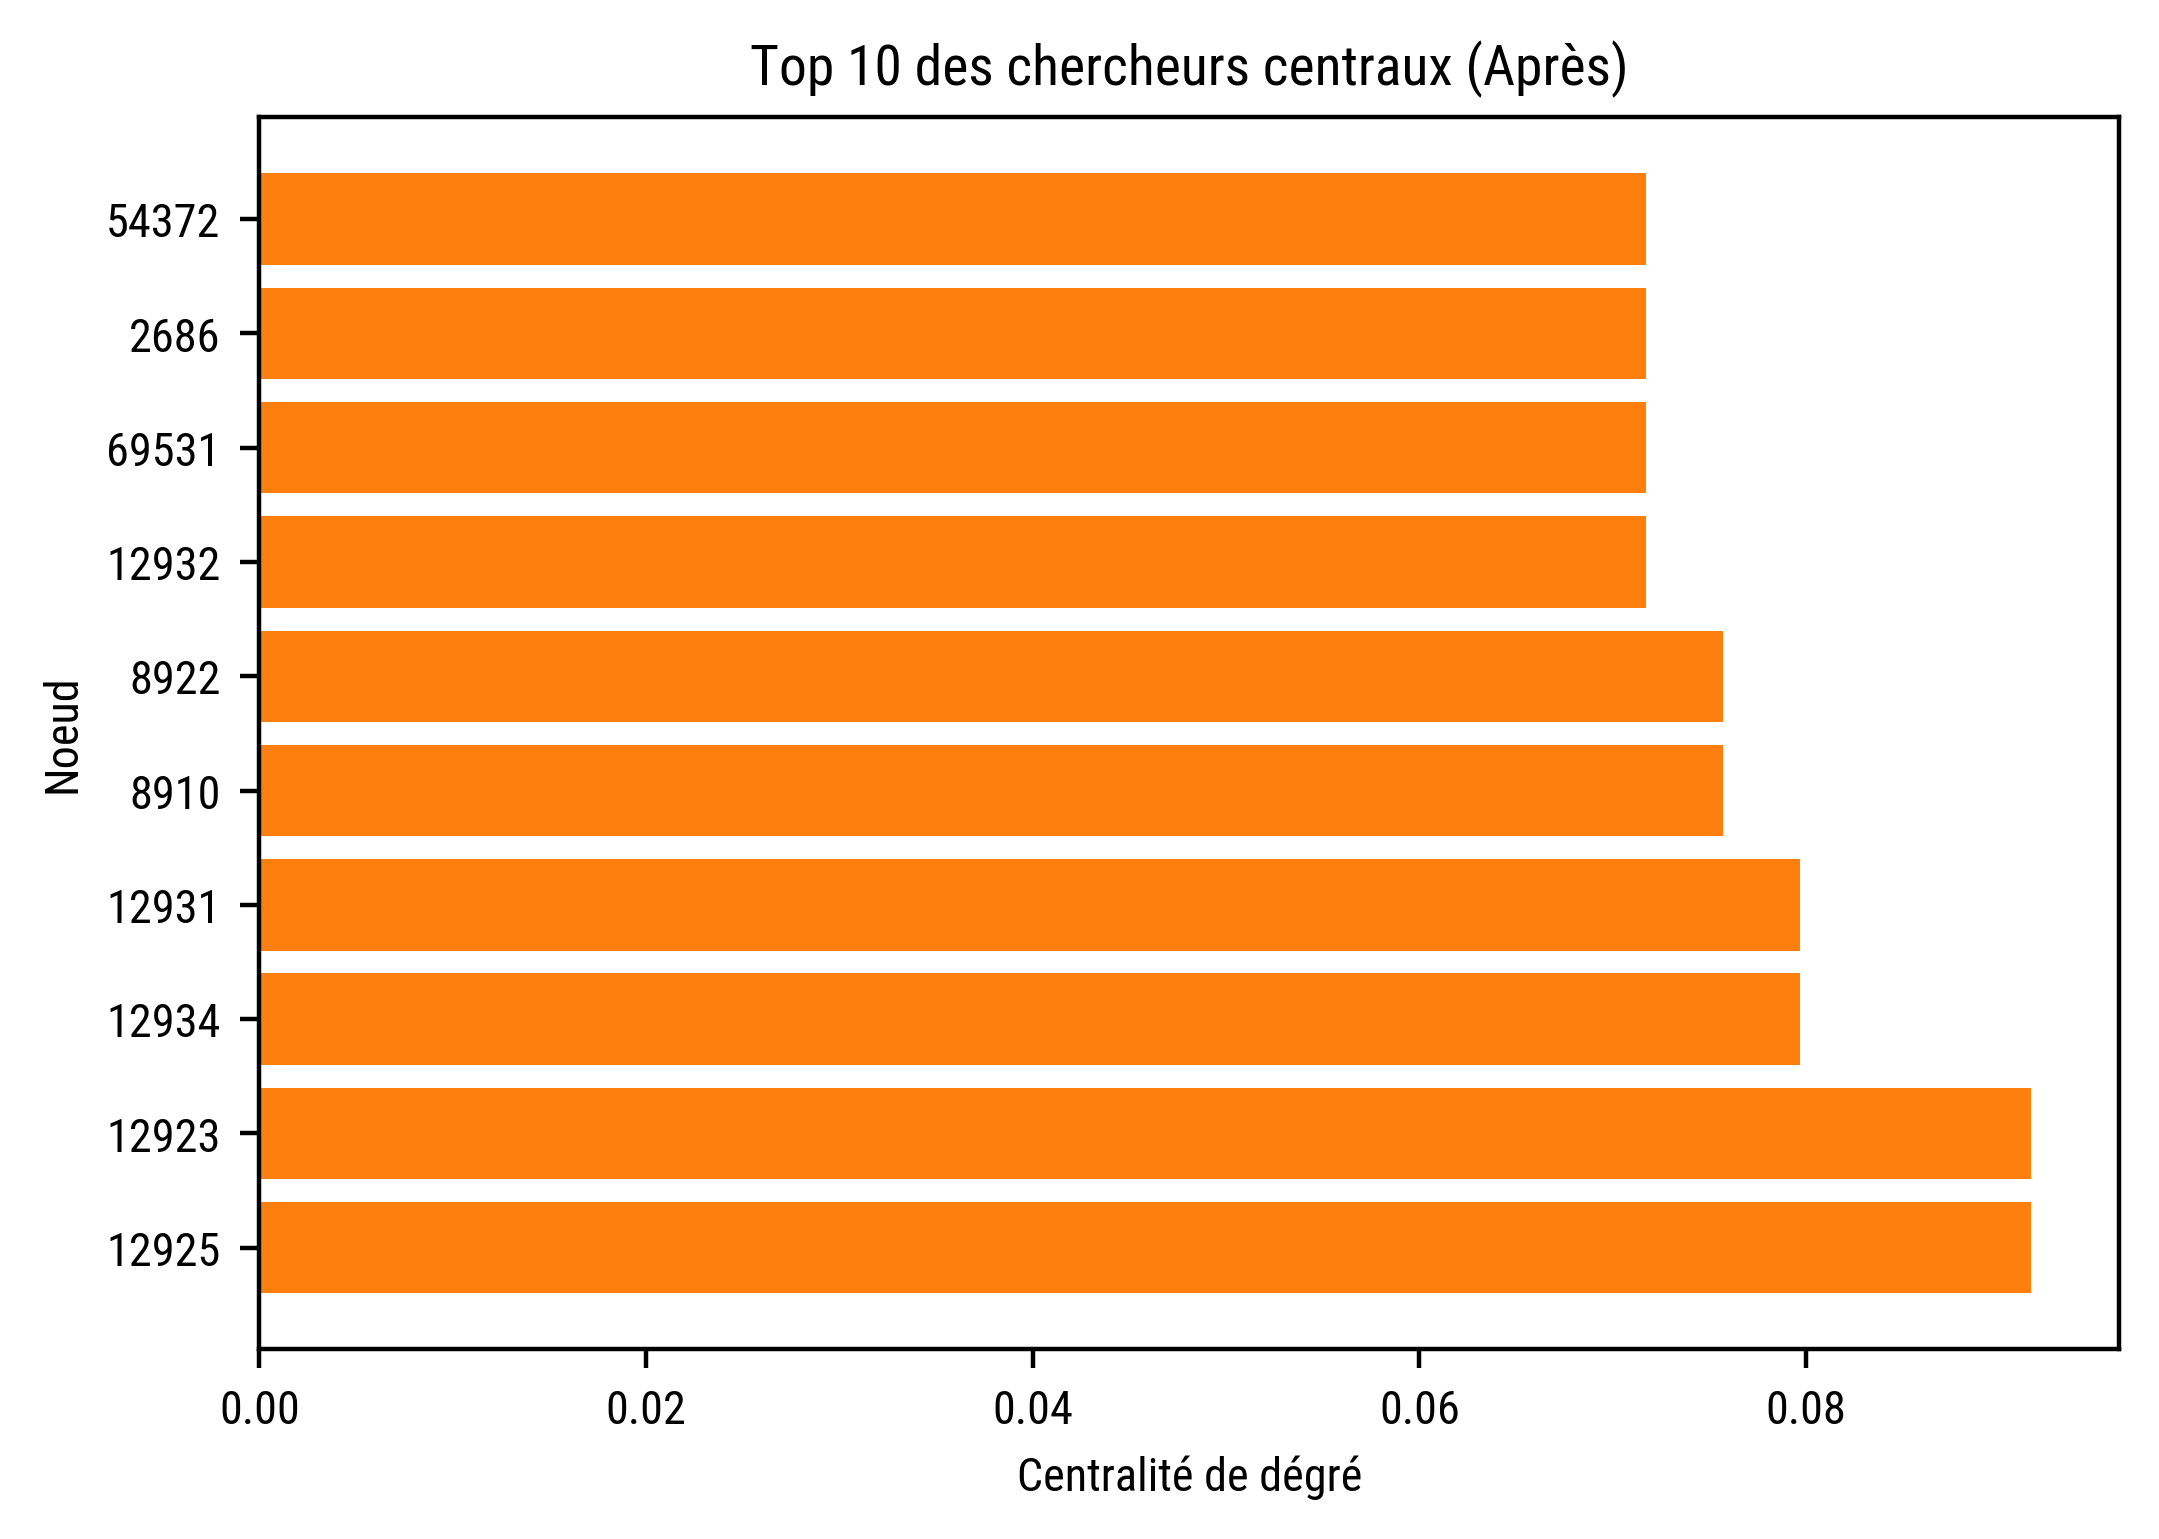

In [31]:
# centralité de dégrés après la mise en place de la politique (Après)
degree_centra = sorted(nx.degree_centrality(G_after).items(), key=lambda x: x[1], reverse=True)[:number_of_element_to_inspect]
nodes = [str(n) for n, d in degree_centra]
degree = [d for n, d in degree_centra]
plt.figure(figsize=(6, 4), dpi=400)
plt.barh(nodes, degree, color='tab:orange')
plt.xlabel("Centralité de dégré")
plt.ylabel("Noeud")
# plt.title(f"Top {number_of_element_to_inspect} des chercheurs ayant le plus de colaborateurs (Après)")
plt.title(f"Top {number_of_element_to_inspect} des chercheurs centraux (Après)")
plt.savefig('graph10.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)
plt.show()

A travers les résultats obtenues sur cet analyse de centralité avant et après la mise en place de la politique, on peut constater que entre les deux périodes les 10 chercheurs possédant le nombres le plus important de collaborations sont assez différents à l'exception de quelques chercheurs se apparaissant dans les deux périodes (à l'exemple du chercheur avec l'identifiant 12923). Cela sous-entend que certains chercheurs influent (*possédant un nombre important de collaboration*) avant la mise en place de la politique le sont devenus moins aux profits d'autres chercheurs qui sont devenus plus influent, également certains chercheurs très influent avant la mise en place de la politique le sont devenus moins.

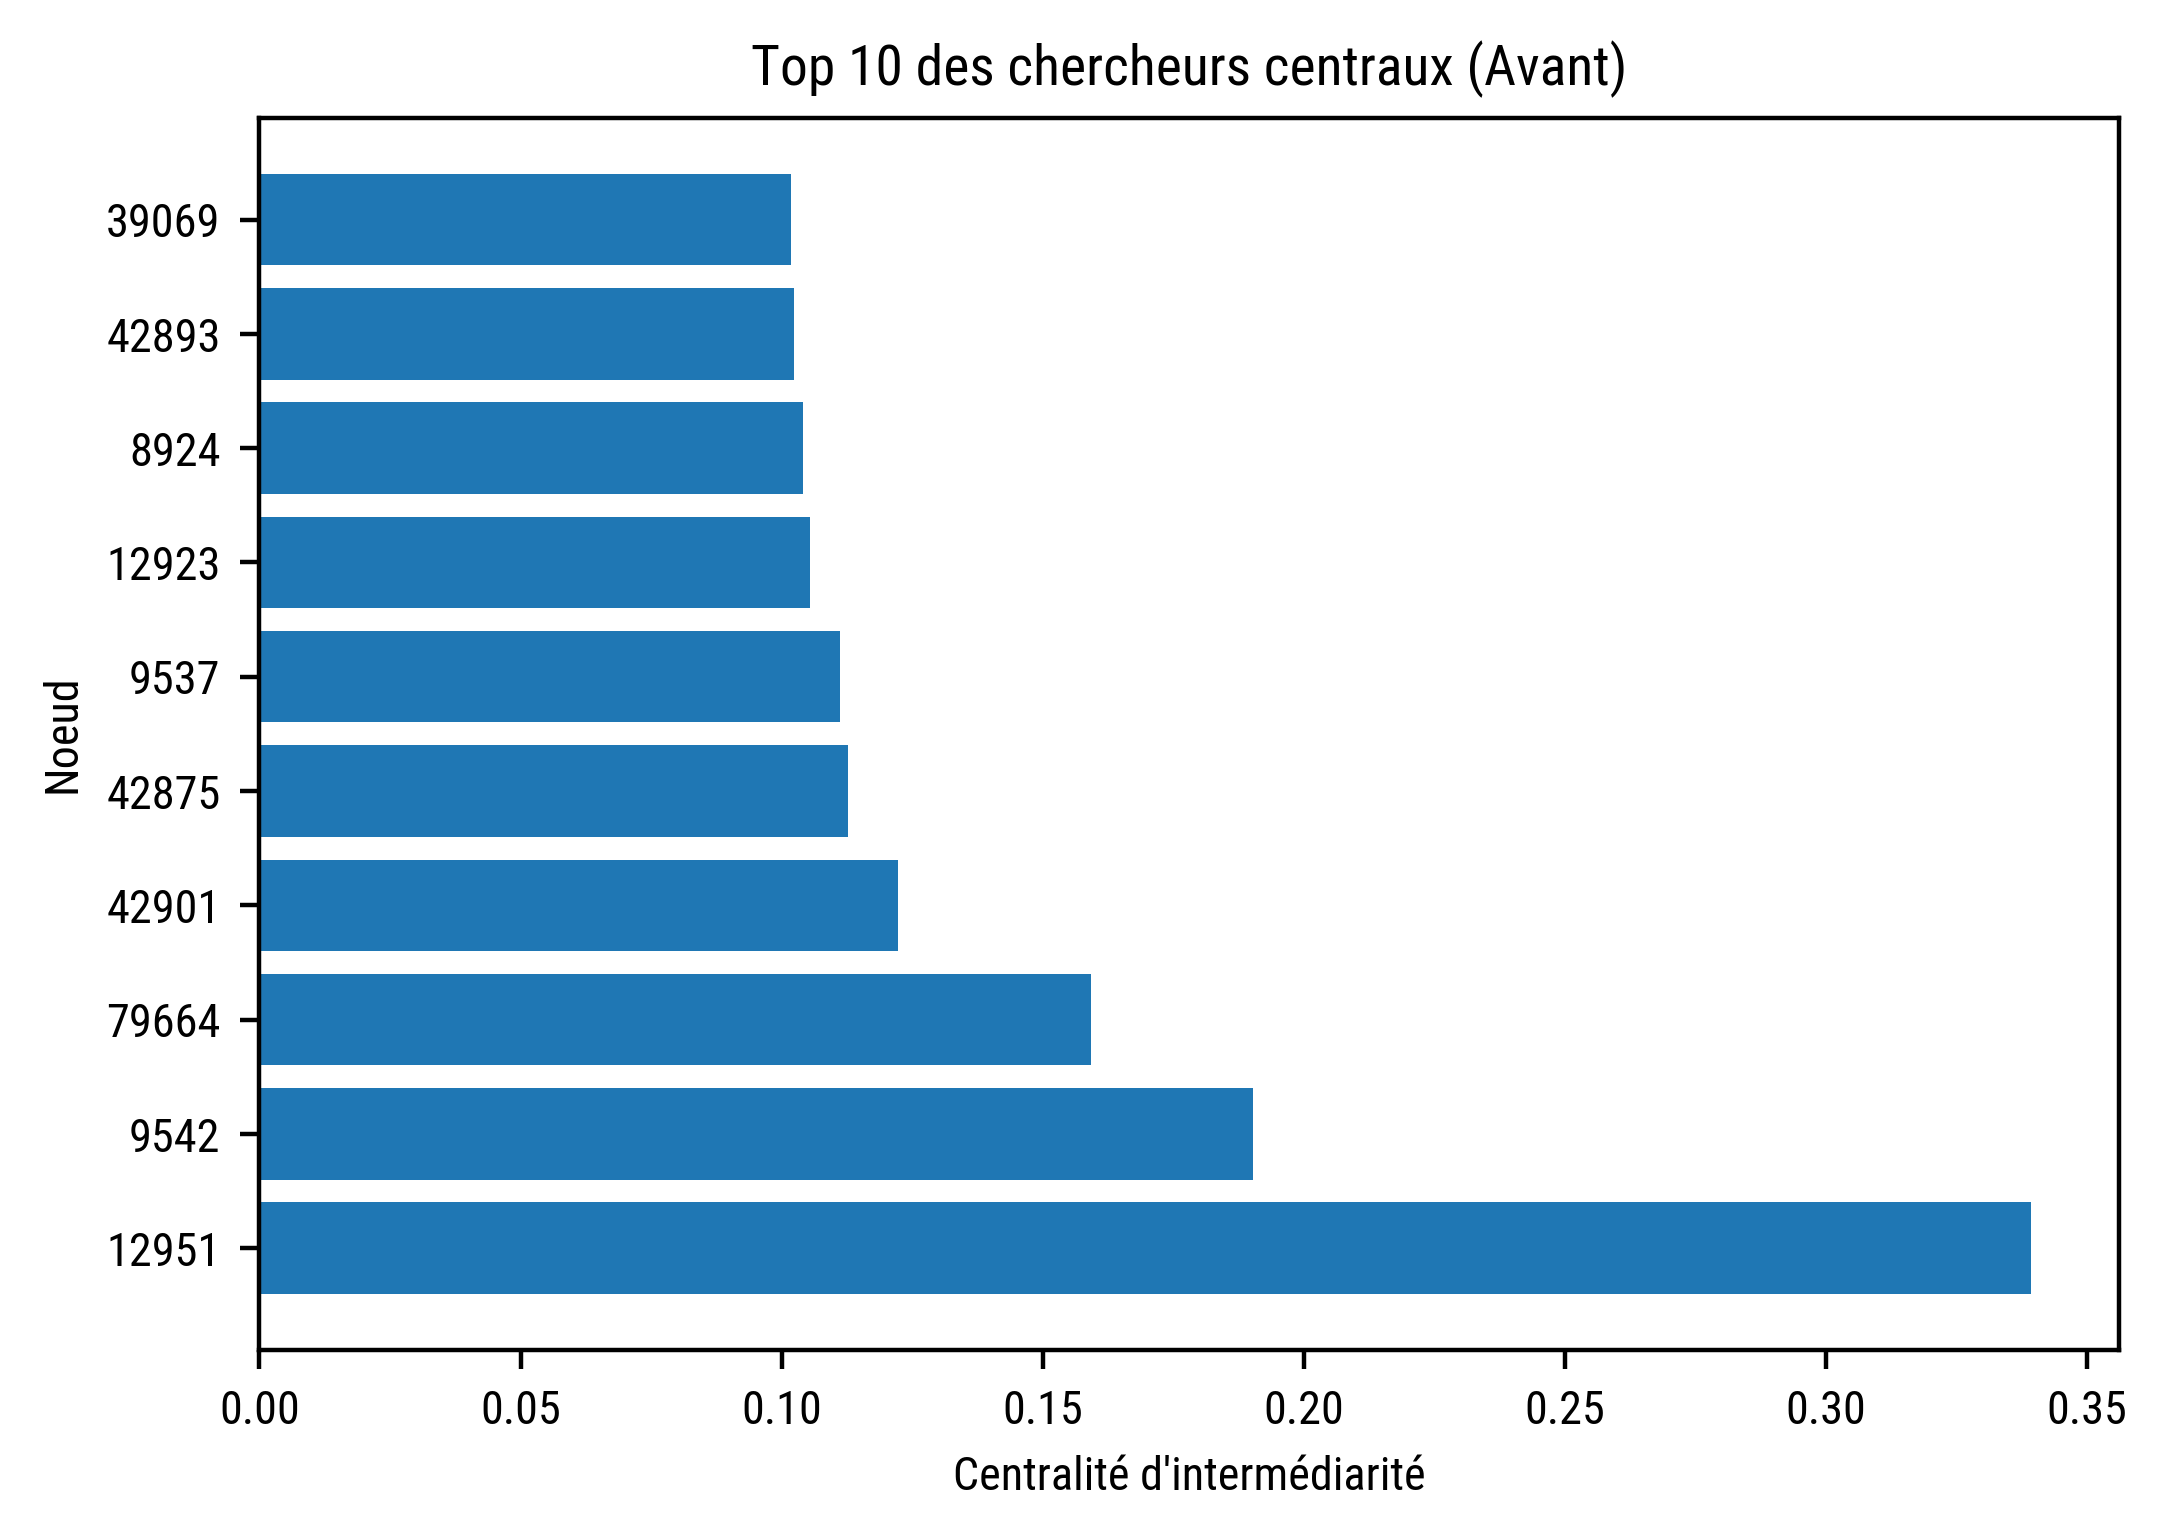

In [32]:
# centralité d'intermédiarité (Avant)
between_centra = sorted(nx.betweenness_centrality(G_before).items(), key=lambda x: x[1], reverse=True)[:number_of_element_to_inspect]
nodes = [str(n) for n, d in between_centra]
degree = [d for n, d in between_centra]
# visualisation des résultats
plt.figure(figsize=(6, 4), dpi=400)
plt.barh(nodes, degree)
plt.xlabel("Centralité d'intermédiarité")
plt.ylabel("Noeud")
# plt.title(f"Top {number_of_element_to_inspect} des chercheurs à l'origine des colaborations (Avant)")
plt.title(f"Top {number_of_element_to_inspect} des chercheurs centraux (Avant)")
plt.savefig('graph11.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)
plt.show()

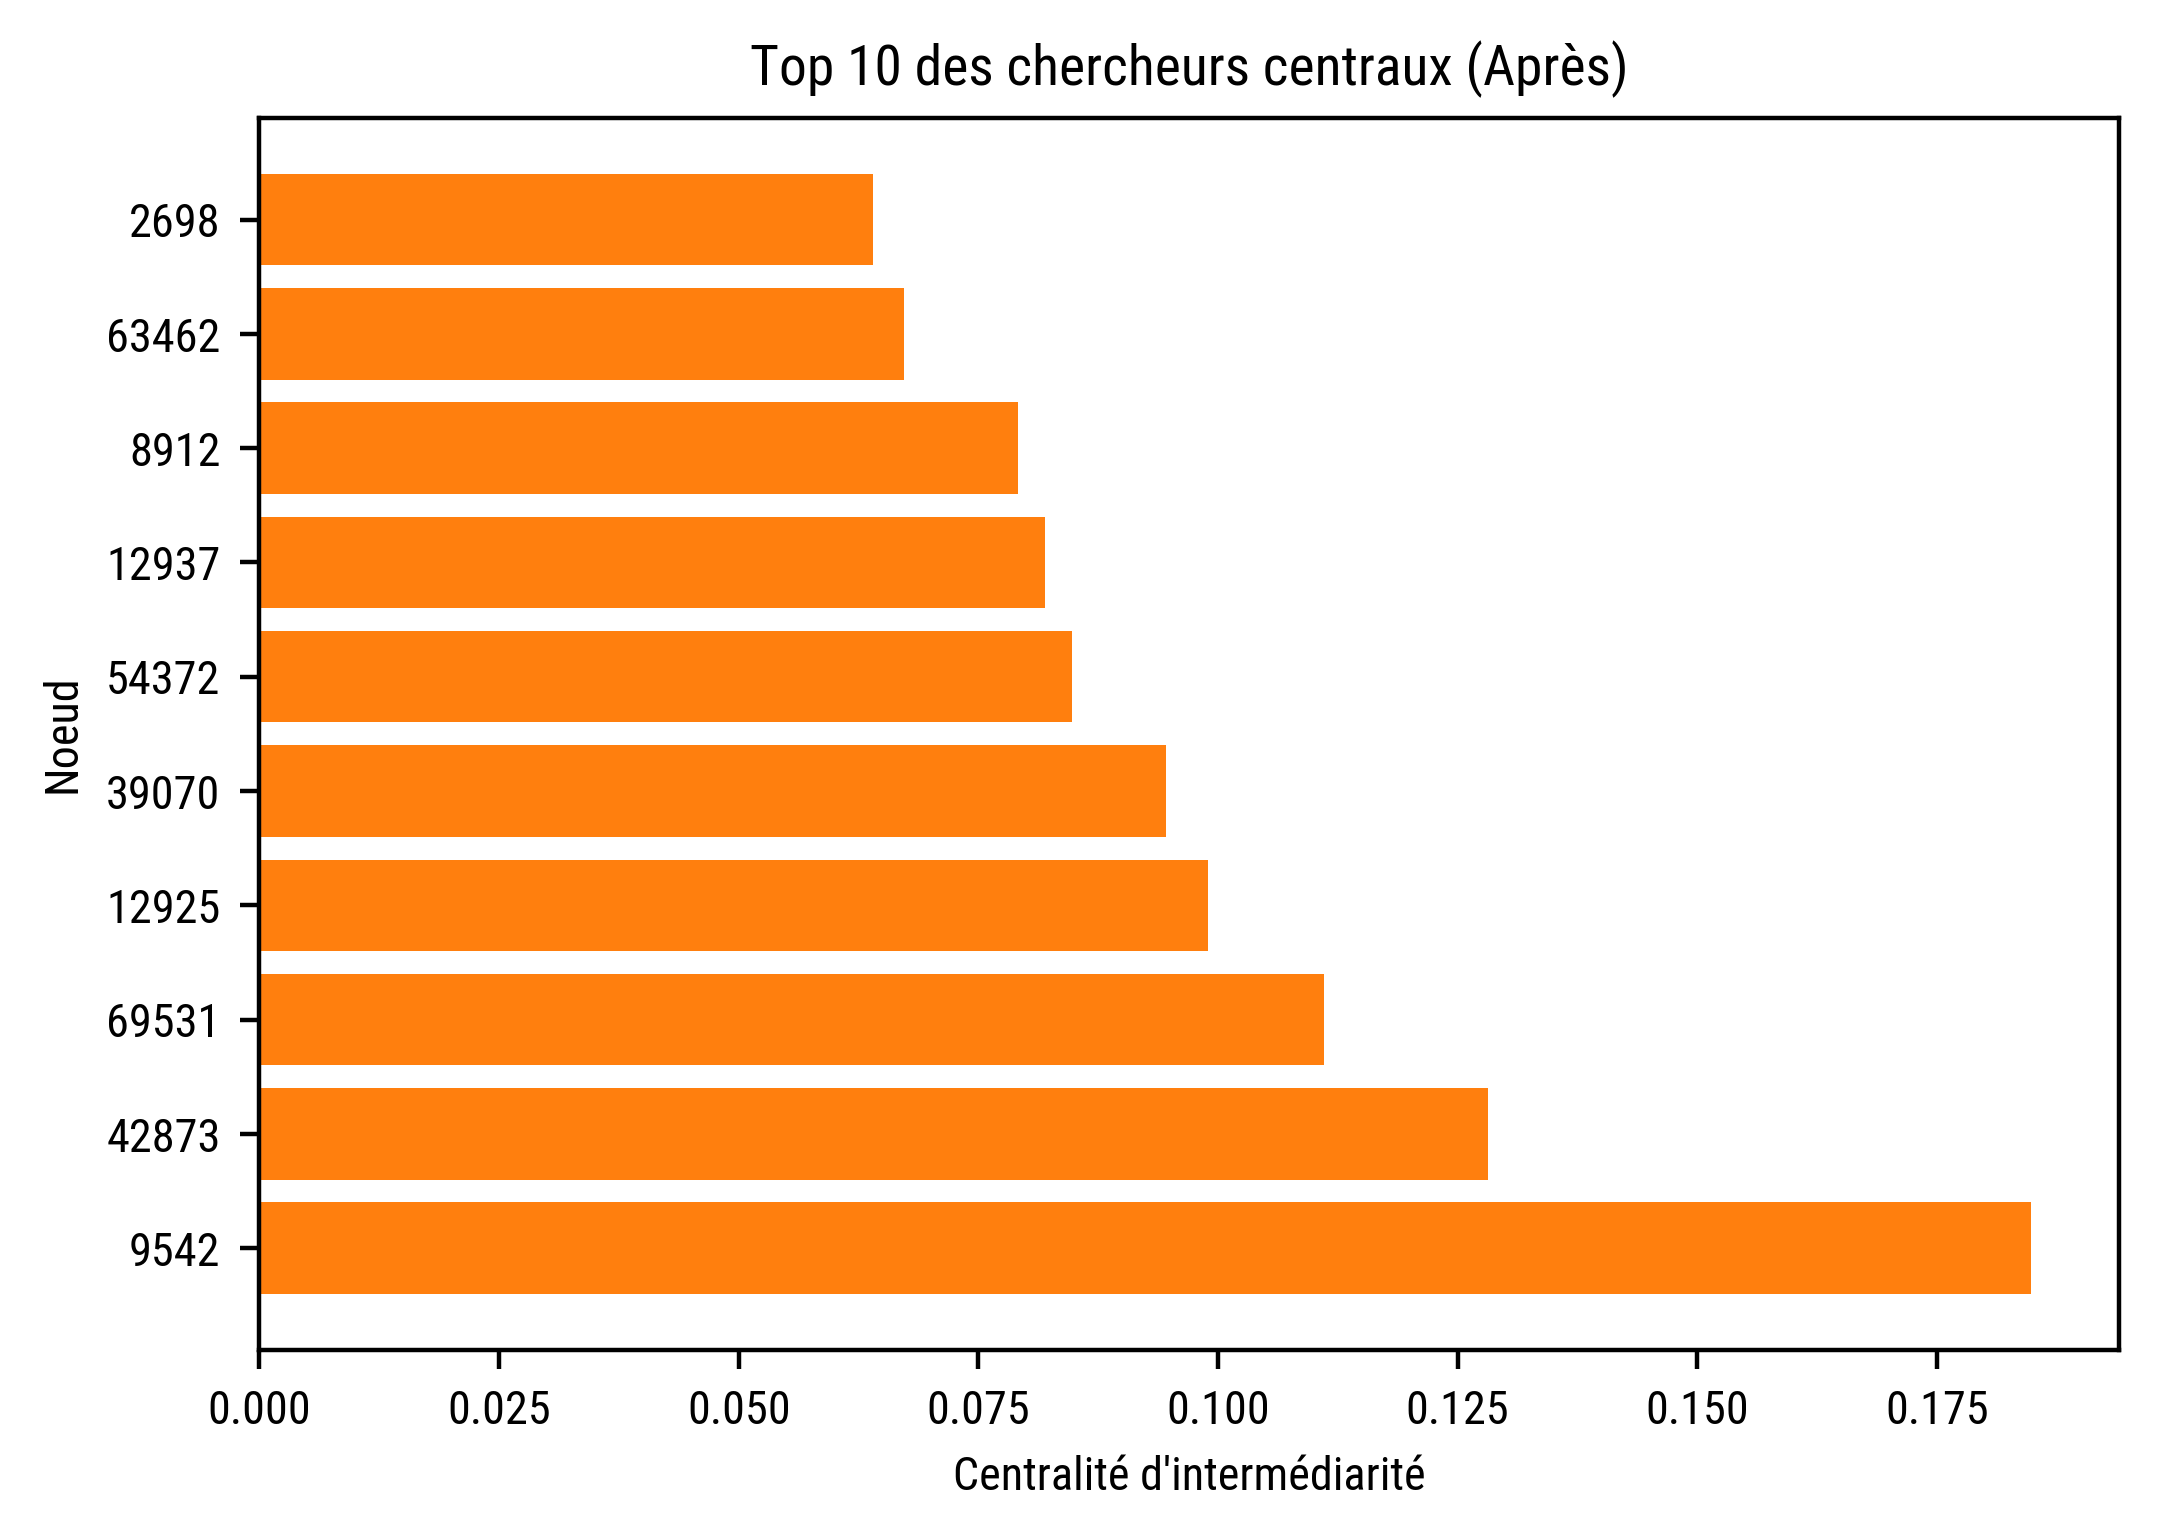

In [33]:
# centralité d'intermédiarité (After)
between_centra = sorted(nx.betweenness_centrality(G_after).items(), key=lambda x: x[1], reverse=True)[:number_of_element_to_inspect]
nodes = [str(n) for n, d in between_centra]
degree = [d for n, d in between_centra]
# visualisation des résultats
plt.figure(figsize=(6, 4), dpi=400)
plt.barh(nodes, degree, color='tab:orange')
plt.xlabel("Centralité d'intermédiarité")
plt.ylabel("Noeud")
# plt.title(f"Top {number_of_element_to_inspect} des chercheurs à l'origine des colaborations (Après)")
plt.title(f"Top {number_of_element_to_inspect} des chercheurs centraux (Après)")
plt.savefig('graph12.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)
plt.show()

Au regard des résultats obtenues en utilisant la mesure d'intermédiarité, on peut constater que les 10 chercheurs favorisant la collaborations entre le reste des autres chercheurs et donc le partage de connaissance (les chercheurs les plus centraux) sont totalement différent entre les deux périodes (**à l'excepetion du chercheur 9542 ayant obtenu plus de collaboration**), indiquant ainsi un réagencement des collaborations avant et après la mise en place de la politique.

**En comparant les résultats obtenues aves la mesure de centralité de dégré et celle obtenue avec la mesure de centralité d'intermédiartié on peut observer que ces deux approches nous donnes des individus assez différent.
Ainsi nous pouvons dire que l'influence des individus dans le réseau est pluridimensionnelle. Certains individus sont influents en raison de leur grand nombre de collaborations directes (degré élevé), tandis que d'autres le sont en raison de leur position stratégique dans le réseau (betweenness élevée).**

## Objectif 2

- Est-ce que les femmes ont un réseau plus dense que celui des hommes ?
- Est-ce que les femmes sont plus central dans le réseau que les hommes ?
- Elargissent-elles plus/moins leur réseau par rapport aux hommes bénéficiant du traitement (au fil du temps) ?
- Peut-on identifier des sous communauté ou detecter de l'homophilie à l'intérieur du réseaux avant et après la mise en place de la politique ?
- Comment cela évolue t'il après la mise en place de la politique ?
- L'appartenance au groupe des coordinateurs modifie-t-elle ces évolutions ?

---

**Est-ce que les femmes ont un réseau plus dense que celui des hommes ?**

L'approche que nous apdotons pour répondre à cette question, consiste à calculer le degré moyen (correspondant au nombre de collaborations en moyenne) pour chaque genre sur l'ensemble du graphe et sur les deux périodes données. Ainsi nous pourrons obervés si entre les deux périodes les femmes possédait plus de collaboration en moyenne.

In [36]:
# calcul du degré avant
degree_before = dict(nx.degree(G_before))
# calcul du degré après
degree_after = dict(nx.degree(G_after))
# on identifie les noeuds de chaque genre
male_nodes = [n for n, data in G_before.nodes(data=True) if int(data['gender']) == 0]
female_nodes = [n for n, data in G_before.nodes(data=True) if int(data['gender']) == 1]
# nombre de noeud de chaque genre
N_male = len(male_nodes)
N_female = len(female_nodes)

# calcul du degré moyen pour les hommes et pour les femmes avant
### dans une première approche on peut construire une list contenant les degrés de chaque genre
### puis en faire la somme de ces valeurs et diviser par le nombre d'éléments mais cela nous
### à un cout au niveau de la mémoire nous obligeant à créer structure de donnée en plus pas forcément necessaire.
### Ainsi nous procederons de la manière suivante qui est plus direct et nous épargne une structure de données
### supplémentaire

# initialisation de la somme à 0 avant
degree_sum_male_before = 0
degree_sum_female_before = 0
# on parcours chaque noeud masculin et feminin puis on récupère le degré correspondant dans le dictionnaire de degré
for m_node in male_nodes:
    degree_sum_male_before += degree_before[m_node]
for f_node in female_nodes:
    degree_sum_female_before += degree_before[f_node]

# initialisation de la somme à 0
degree_sum_male_after = 0
degree_sum_female_after = 0
for m_node in male_nodes:
    degree_sum_male_after += degree_after[m_node]
for f_node in female_nodes:
    degree_sum_female_after += degree_after[f_node]

# affichage des résultats
print("-"*80)
print("Degré moyen avant la mise en place de la politique")
print(f"Degré moyen des hommes {round(degree_sum_male_before/N_male, 4)}")
print(f"Degré moyen des femmes {round(degree_sum_female_before/N_female, 4)}")
print("-"*80)
print("Degré moyen après la mise en place de la politique")
print(f"Degré moyen des hommes {round(degree_sum_male_after/N_male, 4)}")
print(f"Degré moyen des femmes {round(degree_sum_female_after/N_female, 4)}")
print("-"*80)

--------------------------------------------------------------------------------
Degré moyen avant la mise en place de la politique
Degré moyen des hommes 6.454
Degré moyen des femmes 3.7528
--------------------------------------------------------------------------------
Degré moyen après la mise en place de la politique
Degré moyen des hommes 6.2454
Degré moyen des femmes 5.1685
--------------------------------------------------------------------------------


Ainsi on remarque, qu'avant tout comme après la mise de la politique, le réseau des hommes est toujours plus dense que celui des femmes. Néanmoins ont peut constater qu'entre les deux périodes le nombre de collaboration moyenne pour le genre feminin a largement augmenté tandis que celui des hommes à subit une légère baisse.

---

In [37]:
# Est-ce que les femmes sont plus central dans le réseau que les hommes ?
degree_centra_before = nx.degree_centrality(G_before)
degree_centra_after = nx.degree_centrality(G_after)
between_centra_before = nx.betweenness_centrality(G_before)
between_centra_after = nx.betweenness_centrality(G_after)

In [38]:
# centralité de dégré pour chaque genre
degree_centra_male_before = {node: degree_centra_before[node] for node in male_nodes}
degree_centra_female_before = {node: degree_centra_before[node] for node in female_nodes}
degree_centra_male_after = {node: degree_centra_after[node] for node in male_nodes}
degree_centra_female_after = {node: degree_centra_after[node] for node in female_nodes}
# centralité betweeness pour chaque genre
degree_between_male_before = {node: between_centra_before[node] for node in male_nodes}
degree_between_female_before = {node: between_centra_before[node] for node in female_nodes}
degree_between_male_after = {node: between_centra_after[node] for node in male_nodes}
degree_between_female_after = {node: between_centra_after[node] for node in female_nodes}

In [39]:
# comparaison des résultat par la moyenne du score de centralité par genre
print("-"*80)
print(f"centralité de dégré moyenne pour les femmes avant le traitement {round(np.mean(list(degree_centra_female_before.values())), 4)}")
print(f"centralité de dégré moyenne pour les hommes avant le traitement {round(np.mean(list(degree_centra_male_before.values())), 4)}")
print(f"centralité de dégré moyenne pour les femmes après le traitement {round(np.mean(list(degree_centra_female_after.values())), 4)}")
print(f"centralité de dégré moyenne pour les hommes après le traitement {round(np.mean(list(degree_centra_male_after.values())), 4)}")
print("-"*80)
print(f"betweenness centrality moyenne pour les femmes avant le traitement {round(np.mean(list(degree_between_female_before.values())), 4)}")
print(f"betweenness centrality moyenne pour les hommes avant le traitement {round(np.mean(list(degree_between_male_before.values())), 4)}")
print(f"betweenness centrality moyenne pour les femmes après le traitement {round(np.mean(list(degree_between_female_after.values())), 4)}")
print(f"betweenness centrality moyenne pour les hommes après le traitement {round(np.mean(list(degree_between_male_after.values())), 4)}")
print("-"*80)

--------------------------------------------------------------------------------
centralité de dégré moyenne pour les femmes avant le traitement 0.015
centralité de dégré moyenne pour les hommes avant le traitement 0.0257
centralité de dégré moyenne pour les femmes après le traitement 0.0206
centralité de dégré moyenne pour les hommes après le traitement 0.0249
--------------------------------------------------------------------------------
betweenness centrality moyenne pour les femmes avant le traitement 0.0101
betweenness centrality moyenne pour les hommes avant le traitement 0.0177
betweenness centrality moyenne pour les femmes après le traitement 0.0114
betweenness centrality moyenne pour les hommes après le traitement 0.0122
--------------------------------------------------------------------------------


Les résultats obtenues montrent que la mise en place de la politique ne modifie par l'importance des chercheurs masculin dans le réseau, bien que l'importance des chercheurs masculins entre les deux périodes ait baissé celui-ci reste légèrement supérieur à celui des femmes.

---

**Elargissent-elles plus/moins leur réseau par rapport aux hommes bénéficiant du traitement (au fil du temps) ?**
Pour évaluer cela, on calculera le changement de degré (nombre de nouvelles connexions) entre la période de prétraitement et de post-traitement pour chaque sexe. Par la suite nous effectuerons une comparaison du changement moyen de degré entre les sexes.

In [40]:
degree_before = dict(G_before.degree())
degree_after = dict(G_after.degree())

degree_before_female = [degree_before[node] for node in female_nodes]
degree_after_female = [degree_after[node] for node in female_nodes]

degree_before_male = [degree_before[node] for node in male_nodes]
degree_after_male = [degree_after[node] for node in male_nodes]

diff_degree_female = [after - before for before, after in zip(degree_before_female, degree_after_female)]
diff_degree_male = [after - before for before, after in zip(degree_before_male, degree_after_male)]

In [41]:
# affichage
print(f"changement moyen en nombre de connexion dans le groupe des femmes {round(np.mean(diff_degree_female), 4)}")
print(f"changement moyen en nombre de connexion dans le groupe des hommes {round(np.mean(diff_degree_male), 4)}")

changement moyen en nombre de connexion dans le groupe des femmes 1.4157
changement moyen en nombre de connexion dans le groupe des hommes -0.2086


In [42]:
# Peut-on identifier des sous communauté ou detecter de l'homophilie à l'intérieur du réseaux avant et après la mise en place de la politique ?
partition_before = nx.community.louvain_communities(G_before, resolution=0.7, seed=123)
print("nb de communautés (louvain) :", len(partition_before))

# mesure de la modularité
print("modularité (louvain) : ", round(nx.community.modularity(G_before, partition_before),2))

nb de communautés (louvain) : 39
modularité (louvain) :  0.65


In [43]:
partition_after =  nx.community.louvain_communities(G_after, resolution=0.7, seed=123)
print("nb de communautés (louvain) :", len(partition_after))

#mesure de la modularité
print("modularité (louvain) : ", round(nx.community.modularity(G_after, partition_after),2))

nb de communautés (louvain) : 30
modularité (louvain) :  0.67


In [44]:
# algorithme maximisant la modularité
greed_before = nx.community.greedy_modularity_communities(G_before)
print("nb de communautés (greedy mod. before) :", len(greed_before))
print("modularité (greedy mod. before) : ", round(nx.community.modularity(G_after, greed_before),2))

nb de communautés (greedy mod. before) : 40
modularité (greedy mod. before) :  0.38


In [45]:
# algorithme maximisant la modularité
greed_after = nx.community.greedy_modularity_communities(G_after)
print("nb de communautés (greedy mod.) :", len(greed_after))
print("modularité (greedy mod.) : ", round(nx.community.modularity(G_after, greed_after),2))

nb de communautés (greedy mod.) : 32
modularité (greedy mod.) :  0.65


In [46]:
# a list of colormap of 40 value
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
          '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
          '#c7e9c0', '#fdd0a2', '#bcbd22', '#ff9896', '#8c6d31',
          '#9c9ede', '#637939', '#e7cb94', '#6b6ecf', '#b5cf6b',
          '#7570b3', '#d95f02', '#1b9e77', '#d8b365', '#5ab4ac',
          '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d']
# couleur des noeuds avant
nodes_colors_before = [COLORS[idx] for idx in range(len(partition_before)) for com in partition_before[idx]]
nodes_colors_after = [COLORS[idx] for idx in range(len(partition_after)) for com in partition_after[idx]]

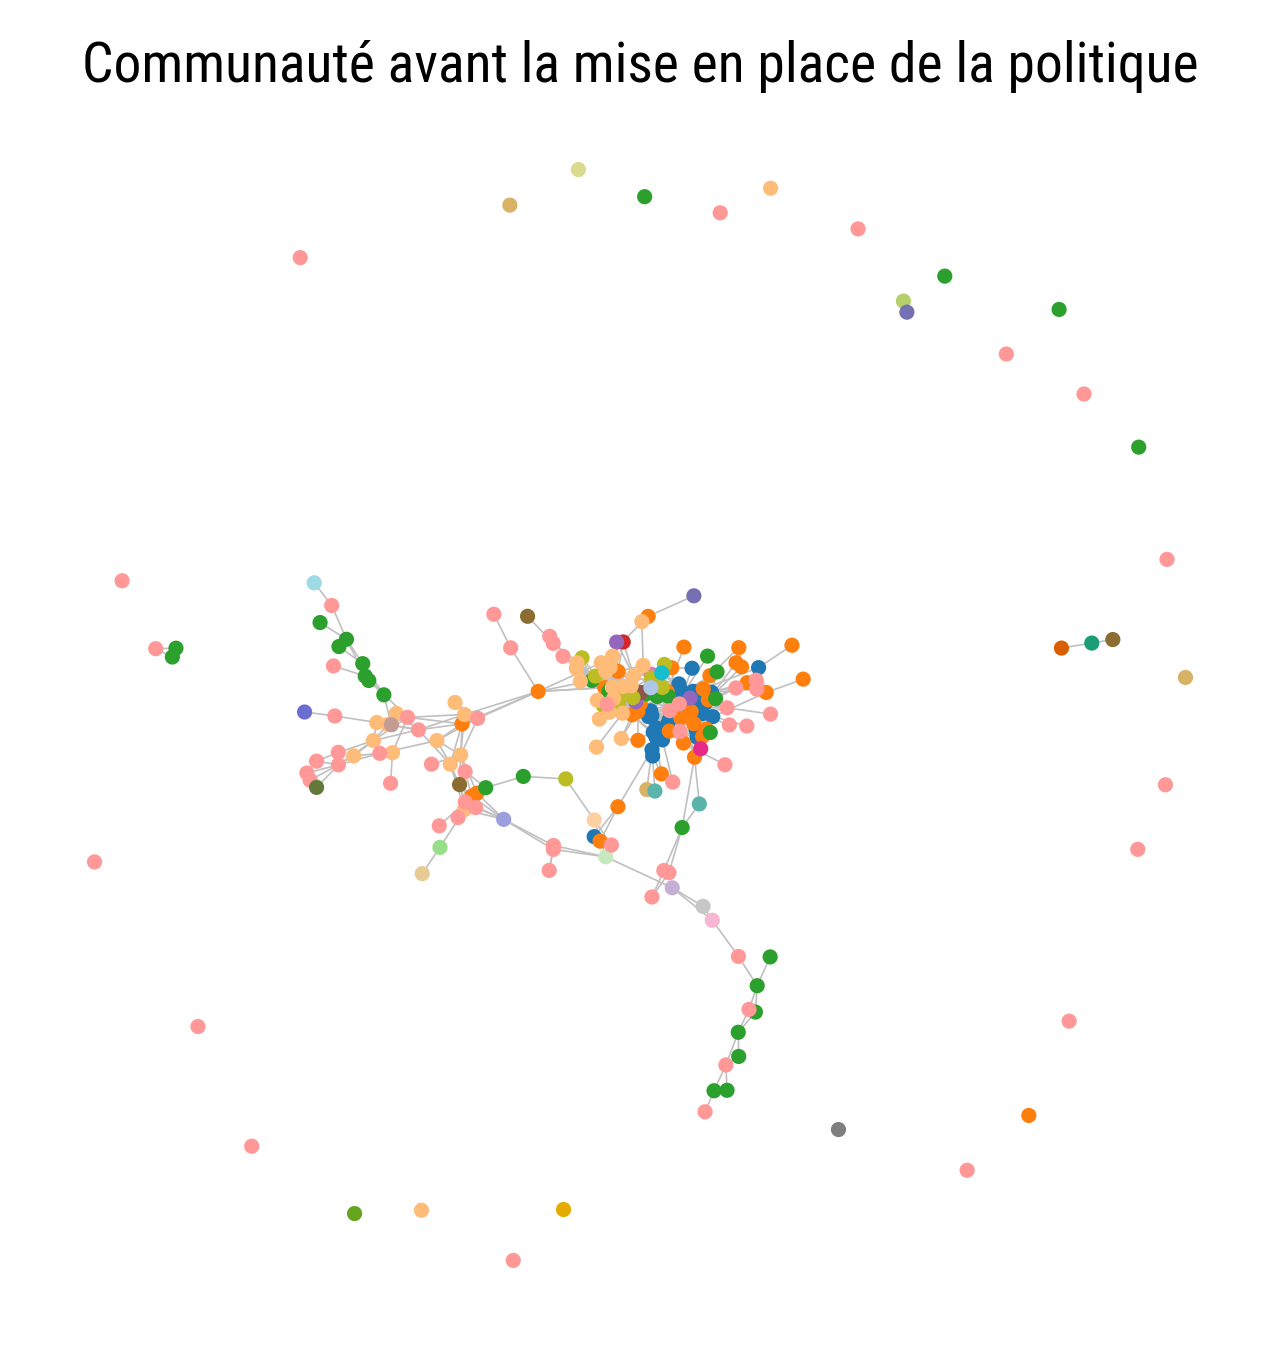

In [47]:
plt.figure(figsize=(3, 3), dpi=400)
nx.draw(G_before, with_labels=False, node_color=nodes_colors_before, node_size=3, edge_color='silver',
        width=.3, pos=nx.layout.spring_layout(G_before))
plt.title("Communauté avant la mise en place de la politique")
plt.savefig('graph15.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)
plt.show()

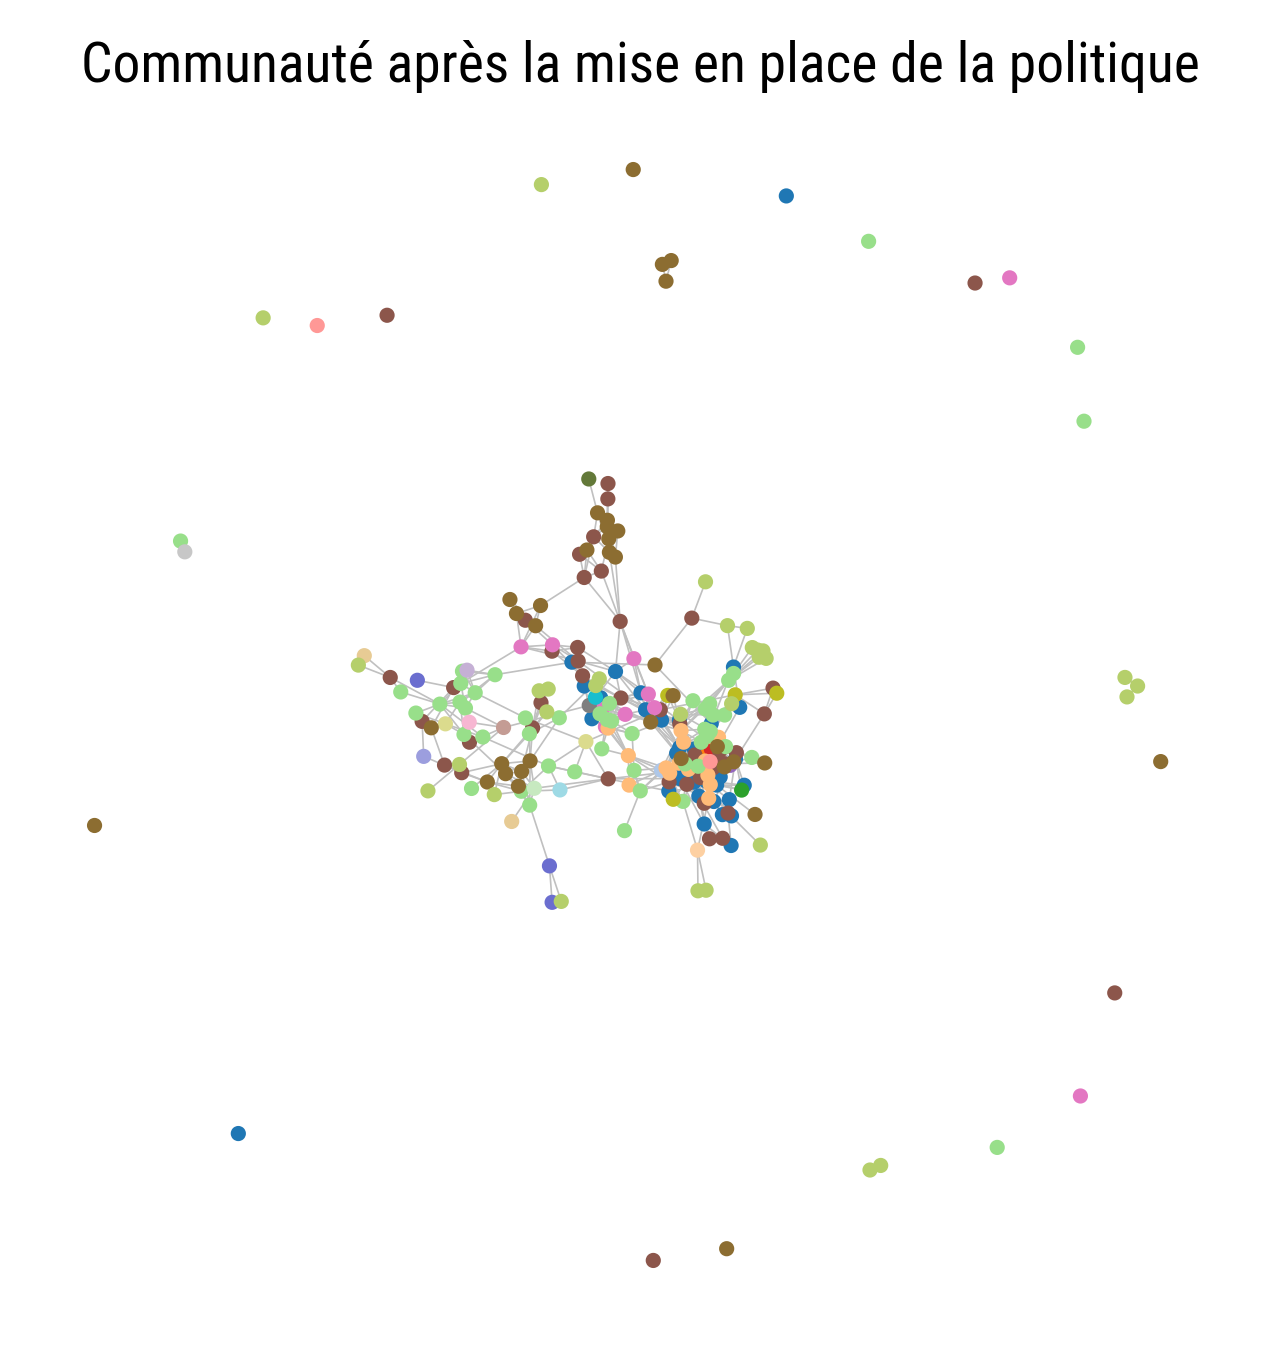

In [48]:
plt.figure(figsize=(3, 3), dpi=400)
nx.draw(G_after, with_labels=False, node_color = nodes_colors_after, node_size=3, edge_color='silver',
        width=.3, pos=nx.layout.spring_layout(G_after))
plt.title("Communauté après la mise en place de la politique")
plt.savefig('graph16.png', transparent=None, dpi='figure', format='png',
            metadata=None, bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto', backend=None)
plt.show()